# **EDA AWAL**

Informasi Dataset Sebelum Pre-Processing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4993 entries, 0 to 4992
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FoodID            4993 non-null   int64  
 1   FoodCategory      4993 non-null   object 
 2   FoodName          4993 non-null   object 
 3   Air               4992 non-null   float64
 4   Energi            4958 non-null   float64
 5   Protein           4832 non-null   float64
 6   Lemak             4723 non-null   float64
 7   Abu               4647 non-null   float64
 8   Karbohidrat       4298 non-null   float64
 9   Serat             3197 non-null   float64
 10  GulaTotal         3235 non-null   float64
 11  Kalsium           4583 non-null   float64
 12  Besi              4773 non-null   float64
 13  Magnesium         4509 non-null   float64
 14  Fosfor            4539 non-null   float64
 15  Kalium            4755 non-null   float64
 16  

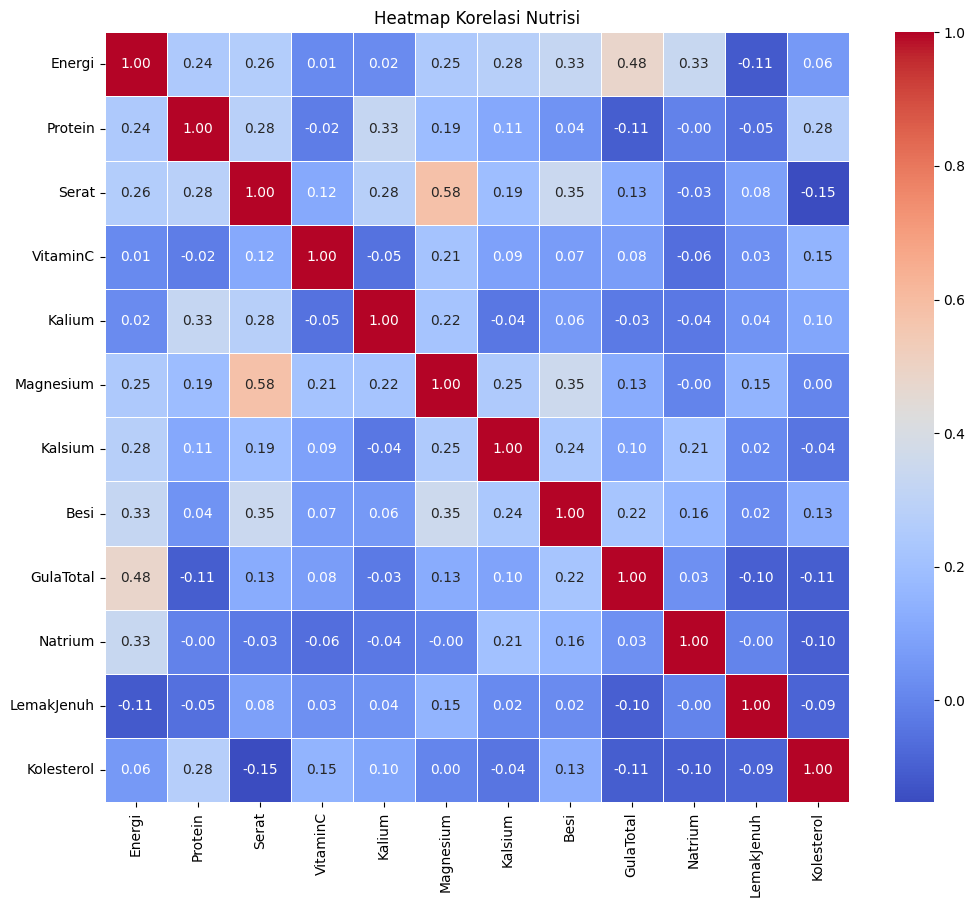

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

github_url = "https://raw.githubusercontent.com/bachtiarrizkyal/TugasAkhir/refs/heads/main/USDAnew.xlsx"
df_usda = pd.read_excel(github_url)

# Melihat informasi dataset
print("Informasi Dataset Sebelum Pre-Processing:")
print(df_usda.info())

# Melihat jumlah data dan kolom
print("\nBentuk Dataset Sebelum Pre-Processing:", df_usda.shape)

# Melihat beberapa data awal
print("\nSample Data Sebelum Pre-Processing:")
print(df_usda.head())

# Melihat statistik deskriptif
print("\nStatistik Deskriptif Sebelum Pre-Processing:")
print(df_usda.describe())

# Melihat nilai yang hilang
print("\nJumlah Nilai yang Hilang per Kolom Sebelum Pre-Processing:")
print(df_usda.isnull().sum())

# Melihat duplikat data
print("\nJumlah Duplikat Data Sebelum Pre-Processing:",df_usda.duplicated().sum())

# Melihat duplikat berdasarkan FoodID
print("\nJumlah Duplikat Berdasarkan FoodID Sebelum Pre-Processing:", df_usda.duplicated(subset=['FoodID']).sum())

# Melihat duplikat berdasarkan FoodName
print("\nJumlah Duplikat Berdasarkan FoodName Sebelum Pre-Processing:", df_usda.duplicated(subset=['FoodName']).sum())

print("Data duplikat berdasarkan 'FoodName':")
print(df_usda[df_usda.duplicated(subset=['FoodName'], keep=False)])

# Melihat distribusi kategori makanan
print("\nDistribusi Kategori Makanan Sebelum Pre-Processing:")
print(df_usda['FoodCategory'].value_counts())

# Melihat heatmap korelasi nutrisi
num_col = ['Energi', 'Protein', 'Serat', 'VitaminC', 'Kalium', 'Magnesium',
                       'Kalsium', 'Besi', 'GulaTotal', 'Natrium', 'LemakJenuh', 'Kolesterol']
correlation_matrix = df_usda[num_col].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap Korelasi Nutrisi')
plt.show()

# **DATA PREPROCESSING**

In [ ]:
def preprocess_data(df):
    # 1. Menghapus data makanan yang mengandung kata 'mentah' dan 'tidak siap'
    df_clean = df[~df['FoodName'].str.contains('mentah|tidak siap', case=False, na=False)]

    # 2. Membuat kolom baru 'FoodGroup' berdasarkan 'FoodCategory'

    food_group_mapping = {
        'Babi': 'Makanan Utama',
        'Daging dan Sosis': 'Makanan Utama',
        'Daging Merah dan Hasil Buruan': 'Makanan Utama',
        'Ikan dan Kerang': 'Makanan Utama',
        'Makanan Cepat Saji': 'Makanan Utama',
        'Sereal dan Pasta': 'Makanan Utama',
        'Unggas': 'Makanan Utama',
        'Makanan Cepat Saji': 'Makanan Utama',
        'Keju, Susu, dan Telur': 'Makanan Pendamping',
        'Makanan Pembuka dan Lauk': 'Makanan Pendamping',
        'Produk Panggang': 'Makanan Pendamping',
        'Sayuran': 'Makanan Pendamping',
        'Sup dan Kaldu': 'Makanan Pendamping',
        'Buah dan Jus': 'Minuman dan Buah',
        'Minuman': 'Minuman dan Buah'
    }
    df_clean['FoodGroup'] = df_clean['FoodCategory'].map(food_group_mapping)

    # Memindahkan kolom FoodGroup agar berada sebelum FoodName
    cols = df_clean.columns.tolist()
    food_name_idx = cols.index('FoodName')

    # Hapus FoodGroup dari posisi aslinya (jika sudah ada, yang seharusnya tidak jika baru dibuat)
    if 'FoodGroup' in cols:
        cols.remove('FoodGroup')
    # Masukkan FoodGroup pada posisi sebelum FoodName
    cols.insert(food_name_idx, 'FoodGroup')
    df_clean = df_clean[cols]

    # Mengisi nilai kosong dengan 0
    df_clean.fillna(0, inplace=True)

    # Menghapus duplikat berdasarkan FoodName
    df_clean = df_clean.drop_duplicates(subset=['FoodName'])

    # Memilih kolom yang akan digunakan
    selected_columns = [
        'FoodID', 'FoodCategory', 'FoodGroup', 'FoodName',
        'Energi', 'Protein', 'Serat', 'VitaminC', 'Kalium', 'Magnesium',
        'Kalsium', 'Besi', 'GulaTotal', 'Natrium', 'LemakJenuh', 'Kolesterol'
    ]
    df_clean = df_clean[selected_columns]

    # Simpan salinan data asli sebelum normalisasi
    df_original = df_clean.copy()

    # Normalisasi data nutrisi
    non_numeric_cols = ['FoodID', 'FoodCategory', 'FoodGroup', 'FoodName']
    numeric_cols = [col for col in df_clean.columns if col not in non_numeric_cols]
    scaler = MinMaxScaler()
    df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

    return df_clean, scaler, df_original, numeric_cols

df_preprocessed, scaler, df_original, nutrient_cols = preprocess_data(df_usda)

# **EDA AKHIR**

Informasi Dataset Setelah Pre-Processing:
<class 'pandas.core.frame.DataFrame'>
Index: 4710 entries, 0 to 4992
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FoodID        4710 non-null   int64  
 1   FoodCategory  4710 non-null   object 
 2   FoodGroup     4710 non-null   object 
 3   FoodName      4710 non-null   object 
 4   Energi        4710 non-null   float64
 5   Protein       4710 non-null   float64
 6   Serat         4710 non-null   float64
 7   VitaminC      4710 non-null   float64
 8   Kalium        4710 non-null   float64
 9   Magnesium     4710 non-null   float64
 10  Kalsium       4710 non-null   float64
 11  Besi          4710 non-null   float64
 12  GulaTotal     4710 non-null   float64
 13  Natrium       4710 non-null   float64
 14  LemakJenuh    4710 non-null   float64
 15  Kolesterol    4710 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 625.5+ KB
None

Bentuk Data

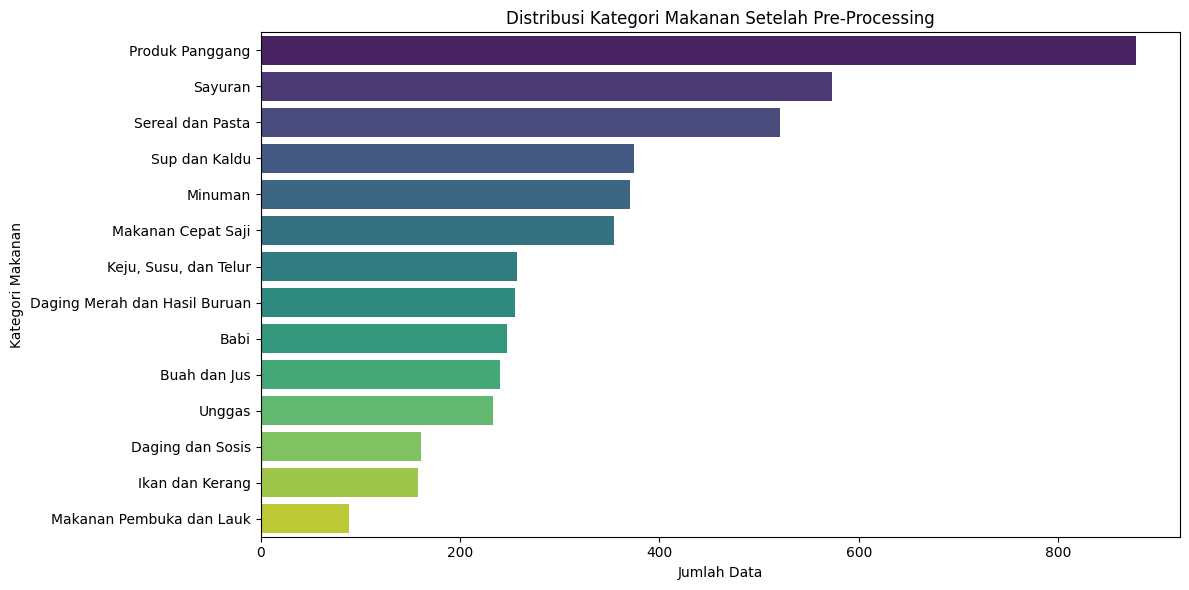

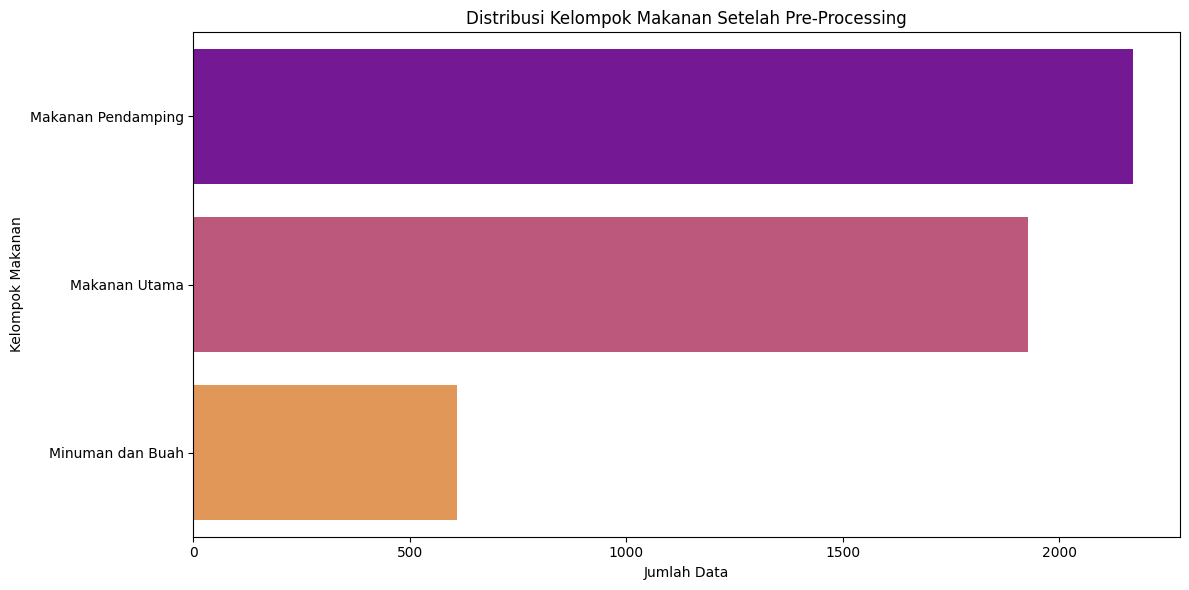

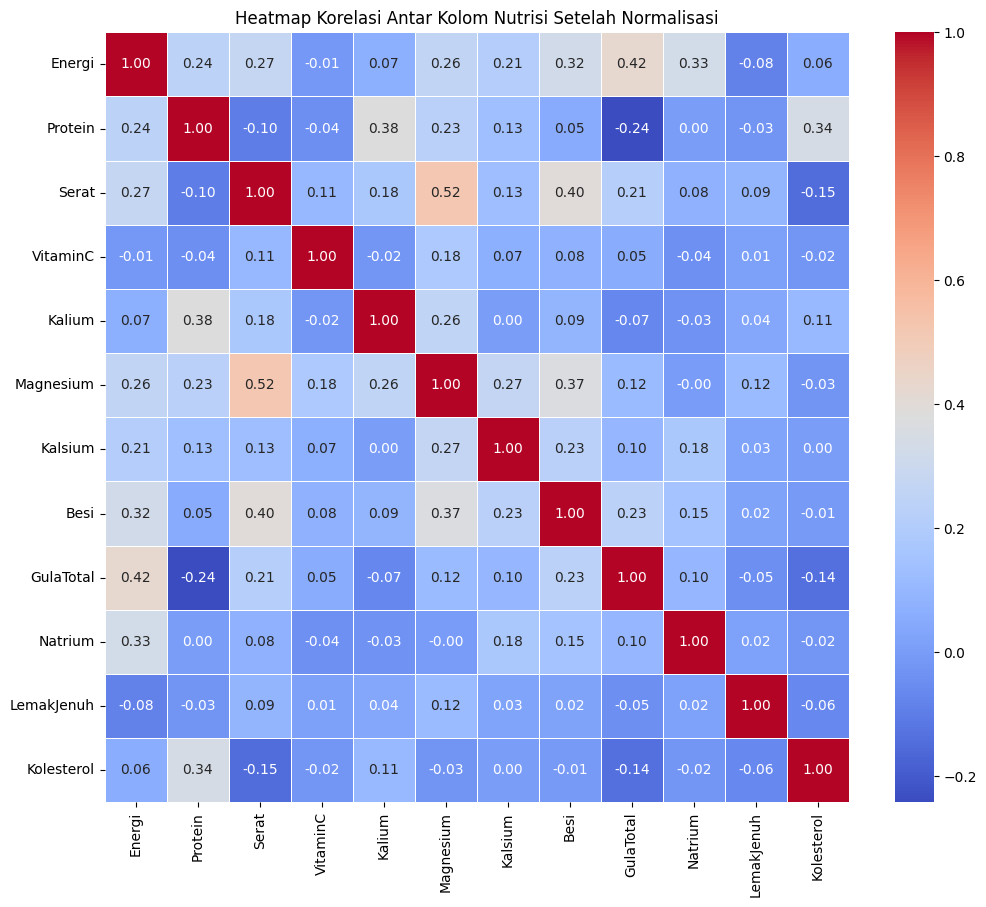

In [ ]:
# Melihat informasi dataset setelah pre-processing
print("Informasi Dataset Setelah Pre-Processing:")
print(df_preprocessed.info())

# Melihat jumlah data dan kolom setelah pre-processing
print("\nBentuk Dataset Setelah Pre-Processing:", df_preprocessed.shape)

# Melihat beberapa data awal setelah pre-processing
print("\nSample Data Setelah Pre-Processing:")
print(df_preprocessed.head())

# Melihat statistik deskriptif setelah pre-processing
print("\nStatistik Deskriptif Setelah Pre-Processing:")
print(df_preprocessed.describe())

# Melihat statistik deskriptif setelah normalisasi
print("\nStatistik Deskriptif Setelah Normalisasi:")
print(df_preprocessed[nutrient_cols].describe())

# Melihat nilai yang hilang setelah pre-processing
print("\nJumlah Nilai yang Hilang per kolom Setelah Pre-Processing:")
print(df_preprocessed.isnull().sum())

# Melihat duplikat data setelah pre-processing
print("\nJumlah Duplikat Data Setelah Pre-Processing:",df_preprocessed.duplicated().sum())

# Melihat duplikat berdasarkan FoodID setelah pre-processing
print("\nJumlah Duplikat Berdasarkan FoodID Setelah Pre-Processing:", df_preprocessed.duplicated(subset=['FoodID']).sum())

# Melihat duplikat berdasarkan FoodName setelah pre-processing
print("\nJumlah Duplikat Berdasarkan FoodName Setelah Pre-Processing:", df_preprocessed.duplicated(subset=['FoodName']).sum())

# Melihat distribusi kategori makanan setelah pre-processing
print("\nDistribusi Kategori Makanan Setelah Pre-Processing:")
print(df_preprocessed['FoodCategory'].value_counts())

# Melihat distribusi kelompok makanan setelah pre-processing
print("\nDistribusi Kelompok Makanan Setelah Pre-Processing:")
print(df_preprocessed['FoodGroup'].value_counts())

# Visualisasi distribusi Kategori Makanan
plt.figure(figsize=(12, 6))
sns.countplot(data=df_preprocessed, y='FoodCategory', order=df_preprocessed['FoodCategory'].value_counts().index, palette='viridis')
plt.title('Distribusi Kategori Makanan Setelah Pre-Processing')
plt.xlabel('Jumlah Data')
plt.ylabel('Kategori Makanan')
plt.tight_layout()
plt.savefig('food_category_distribution.png') # Simpan plot sebagai file gambar
plt.show()

# Visualisasi distribusi Kelompok Makanan
plt.figure(figsize=(12, 6))
sns.countplot(data=df_preprocessed, y='FoodGroup', order=df_preprocessed['FoodGroup'].value_counts().index, palette='plasma')
plt.title('Distribusi Kelompok Makanan Setelah Pre-Processing')
plt.xlabel('Jumlah Data')
plt.ylabel('Kelompok Makanan')
plt.tight_layout()
plt.savefig('food_group_distribution.png') # Simpan plot sebagai file gambar
plt.show()

# Melihat heatmap korelasi nutrisi setelah pre-processing
correlation_matrix = df_preprocessed[nutrient_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap Korelasi Antar Kolom Nutrisi Setelah Normalisasi')
plt.show()

# **USER DATA PROCESSING**

In [ ]:
def calculate_bmi(weight, height):
    height_m = height / 100
    bmi = weight / (height_m ** 2)
    return bmi

def get_bmi_category(bmi):
    if bmi < 18.5:
        return "Berat Badan Kurang (Underweight)"
    elif 18.5 <= bmi < 25:
        return "Berat Badan Normal"
    elif 25 <= bmi < 30:
        return "Berat Badan Berlebih (Overweight)"
    elif 30 <= bmi < 35:
        return "Obesitas I"
    elif 35 <= bmi < 40:
        return "Obesitas II"
    else: # bmi >= 40
        return "Obesitas III"

def calculate_ideal_weight(gender, height):
    if gender.lower() == 'laki-laki':
        return (height - 100) - ((height - 100) * 0.1)
    else:
        return (height - 100) - ((height - 100) * 0.15)

def calculate_energy_needs(gender, age, height, ideal_weight):
    if gender.lower() == 'laki-laki':
        bmr = 66.5 + (13.75 * ideal_weight) + (5.003 * height) - (6.75 * age)
    else:
        bmr = 655.1 + (9.563 * ideal_weight) + (1.850 * height) - (4.676 * age)

    energy_needs = bmr * 1.55
    return energy_needs

def get_age_category(age):
    if 10 <= age <= 18:
        return "remaja"
    elif 19 <= age <= 64:
        return "dewasa"
    else:
        return "lansia"

def get_nutrition_requirements(gender, age, energy_needs, diseases):
    # Mendapatkan kategori usia
    age_category = get_age_category(age)

    # Indeks untuk nilai AKG berdasarkan jenis kelamin dan usia
    idx = 0

    # Remaja laki-laki (10-18 tahun)
    if gender.lower() == 'laki-laki' and age_category == 'remaja':
        if 10 <= age <= 12:
            idx = 0
        elif 13 <= age <= 15:
            idx = 1
        elif 16 <= age <= 18:
            idx = 2

    # Dewasa laki-laki (19-64 tahun)
    elif gender.lower() == 'laki-laki' and age_category == 'dewasa':
        if 19 <= age <= 29:
            idx = 3
        elif 30 <= age <= 49:
            idx = 4
        elif 50 <= age <= 64:
            idx = 5

    # Lansia laki-laki (>64 tahun)
    elif gender.lower() == 'laki-laki' and age_category == 'lansia':
        if 65 <= age <= 80:
            idx = 6
        else:
            idx = 7

    # Remaja perempuan (10-18 tahun)
    elif gender.lower() == 'perempuan' and age_category == 'remaja':
        if 10 <= age <= 12:
            idx = 8
        elif 13 <= age <= 15:
            idx = 9
        elif 16 <= age <= 18:
            idx = 10

    # Dewasa perempuan (19-64 tahun)
    elif gender.lower() == 'perempuan' and age_category == 'dewasa':
        if 19 <= age <= 29:
            idx = 11
        elif 30 <= age <= 49:
            idx = 12
        elif 50 <= age <= 64:
            idx = 13

    # Lansia perempuan (>64 tahun)
    elif gender.lower() == 'perempuan' and age_category == 'lansia':
        if 65 <= age <= 80:
            idx = 14
        else:
            idx = 15

    # AKG Kondisi Normal
    nutrition_req = {
        'GulaTotal': (10 * energy_needs / 100) / 4,
        'Serat': [28, 34, 37, 37, 36, 30, 25, 22, 27, 29, 29, 32, 30, 25, 22, 20][idx],
        'Protein': [50, 70, 75, 65, 65, 65, 64, 64, 55, 65, 65, 60, 60, 60, 58, 58][idx],
        'LemakJenuh': [30, 30, 30, 30, 30, 30, 30, 30, 20, 20, 20, 20, 20, 20, 20, 20][idx],
        'VitaminC': [50, 75, 90, 90, 90, 90, 90, 90, 50, 65, 75, 75, 75, 75, 75, 75][idx],
        'Magnesium': [160, 225, 270, 360, 360, 360, 350, 350, 170, 220, 230, 330, 340, 340, 320, 320][idx],
        'Natrium': [1300, 1500, 1700, 1500, 1500, 1300, 1100, 1000, 1400, 1500, 1600, 1500, 1500, 1400, 1200, 1000][idx],
        'Kalsium': [1200, 1200, 1200, 1000, 1000, 1200, 1200, 1200, 1200, 1200, 1200, 1000, 1000, 1200, 1200, 1200][idx],
        'Kalium': [3900, 4800, 5300, 4700, 4700, 4700, 4700, 4700, 4400, 4800, 5000, 4700, 4700, 4700, 4700, 4700][idx],
        'Besi': [8, 11, 11, 9, 9, 9, 9, 9, 8, 15, 15, 18, 18, 8, 8, 8][idx],
        'Kolesterol': [300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300][idx],
        'Energi': energy_needs
    }

    # AKG Pengidap Penyakit
    if diseases:
        # Pengidap Diabetes
        if 'diabetes' in diseases and 'hipertensi' not in diseases and 'cardiovascular disease' not in diseases:
            nutrition_req.update({
                'Serat': [32.2, 39.1, 42.55, 42.55, 41.4, 34.5, 28.75, 25.3, 31.05, 33.35, 33.35, 36.8, 34.5, 28.75, 25.3, 23][idx],
                'Protein': (20 * energy_needs / 100) / 4,
                'VitaminC': [57.5, 86.25, 103.5, 103.5, 103.5, 103.5, 103.5, 103.5, 57.5, 74.75, 86.25, 86.25, 86.25, 86.25, 86.25, 86.25][idx],
                'GulaTotal': (5 * energy_needs / 100) / 4,
                'LemakJenuh': (7 * energy_needs / 100) / 9,
                'Natrium': [1105, 1275, 1445, 1275, 1275, 1105, 935, 850, 1190, 1275, 1360, 1275, 1275, 1190, 1020, 850][idx],
                'Kolesterol': 200
            })

        # Pengidap Hipertensi
        elif 'hipertensi' in diseases and 'diabetes' not in diseases and 'cardiovascular disease' not in diseases:
            nutrition_req.update({
                'Serat': [32.2, 39.1, 42.55, 42.55, 41.4, 34.5, 28.75, 25.3, 31.05, 33.35, 33.35, 36.8, 34.5, 28.75, 25.3, 23][idx],
                'Magnesium': [184, 258.75, 310.5, 414, 414, 414, 402.5, 402.5, 195.5, 253, 264.5, 379.5, 391, 391, 368, 368][idx],
                'Kalsium': [1380, 1380, 1380, 1150, 1150, 1380, 1380, 1380, 1380, 1380, 1380, 1150, 1150, 1380, 1380, 1380][idx],
                'Kalium': [4485, 5520, 6095, 5405, 5405, 5405, 5405, 5405, 5060, 5520, 5750, 5405, 5405, 5405, 5405, 5405][idx],
                'LemakJenuh': (7 * energy_needs / 100) / 9,
                'Natrium': [1105, 1275, 1445, 1275, 1275, 1105, 935, 850, 1190, 1275, 1360, 1275, 1275, 1190, 1020, 850][idx],
                'Kolesterol': 200
            })

        # Pengidap Cardiovascular Disease
        elif 'cardiovascular disease' in diseases and 'diabetes' not in diseases and 'hipertensi' not in diseases:
            nutrition_req.update({
                'Serat': [32.2, 39.1, 42.55, 42.55, 41.4, 34.5, 28.75, 25.3, 31.05, 33.35, 33.35, 36.8, 34.5, 28.75, 25.3, 23][idx],
                'Protein': (20 * energy_needs / 100) / 4,
                'Besi': [9.2, 12.65, 12.65, 10.35, 10.35, 10.35, 10.35, 10.35, 9.2, 17.25, 17.25, 20.7, 20.7, 9.2, 9.2, 9.2][idx],
                'LemakJenuh': (7 * energy_needs / 100) / 9,
                'Natrium': [1105, 1275, 1445, 1275, 1275, 1105, 935, 850, 1190, 1275, 1360, 1275, 1275, 1190, 1020, 850][idx],
                'Kolesterol': 200
            })

        # Pengidap Diabetes dan Hipertensi
        elif 'diabetes' in diseases and 'hipertensi' in diseases and 'cardiovascular disease' not in diseases:
            nutrition_req.update({
                'Serat': [32.2, 39.1, 42.55, 42.55, 41.4, 34.5, 28.75, 25.3, 31.05, 33.35, 33.35, 36.8, 34.5, 28.75, 25.3, 23][idx],
                'Protein': (20 * energy_needs / 100) / 4,
                'VitaminC': [57.5, 86.25, 103.5, 103.5, 103.5, 103.5, 103.5, 103.5, 57.5, 74.75, 86.25, 86.25, 86.25, 86.25, 86.25, 86.25][idx],
                'Magnesium': [184, 258.75, 310.5, 414, 414, 414, 402.5, 402.5, 195.5, 253, 264.5, 379.5, 391, 391, 368, 368][idx],
                'Kalsium': [1380, 1380, 1380, 1150, 1150, 1380, 1380, 1380, 1380, 1380, 1380, 1150, 1150, 1380, 1380, 1380][idx],
                'Kalium': [4485, 5520, 6095, 5405, 5405, 5405, 5405, 5405, 5060, 5520, 5750, 5405, 5405, 5405, 5405, 5405][idx],
                'GulaTotal': (5 * energy_needs / 100) / 4,
                'LemakJenuh': (7 * energy_needs / 100) / 9,
                'Natrium': [1105, 1275, 1445, 1275, 1275, 1105, 935, 850, 1190, 1275, 1360, 1275, 1275, 1190, 1020, 850][idx],
                'Kolesterol': 200
            })

        # Pengidap Diabetes dan Cardiovascular Disease
        elif 'diabetes' in diseases and 'cardiovascular disease' in diseases and 'hipertensi' not in diseases:
            nutrition_req.update({
                'Serat': [32.2, 39.1, 42.55, 42.55, 41.4, 34.5, 28.75, 25.3, 31.05, 33.35, 33.35, 36.8, 34.5, 28.75, 25.3, 23][idx],
                'Protein': (20 * energy_needs / 100) / 4,
                'VitaminC': [57.5, 86.25, 103.5, 103.5, 103.5, 103.5, 103.5, 103.5, 57.5, 74.75, 86.25, 86.25, 86.25, 86.25, 86.25, 86.25][idx],
                'Besi': [9.2, 12.65, 12.65, 10.35, 10.35, 10.35, 10.35, 10.35, 9.2, 17.25, 17.25, 20.7, 20.7, 9.2, 9.2, 9.2][idx],
                'GulaTotal': (5 * energy_needs / 100) / 4,
                'LemakJenuh': (7 * energy_needs / 100) / 9,
                'Natrium': [1105, 1275, 1445, 1275, 1275, 1105, 935, 850, 1190, 1275, 1360, 1275, 1275, 1190, 1020, 850][idx],
                'Kolesterol': 200
            })

        # Pengidap Hipertensi dan Cardiovascular Disease
        elif 'hipertensi' in diseases and 'cardiovascular disease' in diseases and 'diabetes' not in diseases:
            nutrition_req.update({
                'Serat': [32.2, 39.1, 42.55, 42.55, 41.4, 34.5, 28.75, 25.3, 31.05, 33.35, 33.35, 36.8, 34.5, 28.75, 25.3, 23][idx],
                'Protein': (20 * energy_needs / 100) / 4,
                'Magnesium': [184, 258.75, 310.5, 414, 414, 414, 402.5, 402.5, 195.5, 253, 264.5, 379.5, 391, 391, 368, 368][idx],
                'Kalsium': [1380, 1380, 1380, 1150, 1150, 1380, 1380, 1380, 1380, 1380, 1380, 1150, 1150, 1380, 1380, 1380][idx],
                'Kalium': [4485, 5520, 6095, 5405, 5405, 5405, 5405, 5405, 5060, 5520, 5750, 5405, 5405, 5405, 5405, 5405][idx],
                'Besi': [9.2, 12.65, 12.65, 10.35, 10.35, 10.35, 10.35, 10.35, 9.2, 17.25, 17.25, 20.7, 20.7, 9.2, 9.2, 9.2][idx],
                'LemakJenuh': (7 * energy_needs / 100) / 9,
                'Natrium': [1105, 1275, 1445, 1275, 1275, 1105, 935, 850, 1190, 1275, 1360, 1275, 1275, 1190, 1020, 850][idx],
                'Kolesterol': 200
            })

        # Pengidap Diabetes, Hipertensi, dan Cardiovascular Disease
        elif 'diabetes' in diseases and 'hipertensi' in diseases and 'cardiovascular disease' in diseases:
            nutrition_req.update({
                'Serat': [32.2, 39.1, 42.55, 42.55, 41.4, 34.5, 28.75, 25.3, 31.05, 33.35, 33.35, 36.8, 34.5, 28.75, 25.3, 23][idx],
                'Protein': (20 * energy_needs / 100) / 4,
                'VitaminC': [57.5, 86.25, 103.5, 103.5, 103.5, 103.5, 103.5, 103.5, 57.5, 74.75, 86.25, 86.25, 86.25, 86.25, 86.25, 86.25][idx],
                'Magnesium': [184, 258.75, 310.5, 414, 414, 414, 402.5, 402.5, 195.5, 253, 264.5, 379.5, 391, 391, 368, 368][idx],
                'Kalsium': [1380, 1380, 1380, 1150, 1150, 1380, 1380, 1380, 1380, 1380, 1380, 1150, 1150, 1380, 1380, 1380][idx],
                'Kalium': [4485, 5520, 6095, 5405, 5405, 5405, 5405, 5405, 5060, 5520, 5750, 5405, 5405, 5405, 5405, 5405][idx],
                'Besi': [9.2, 12.65, 12.65, 10.35, 10.35, 10.35, 10.35, 10.35, 9.2, 17.25, 17.25, 20.7, 20.7, 9.2, 9.2, 9.2][idx],
                'GulaTotal': (5 * energy_needs / 100) / 4,
                'LemakJenuh': (7 * energy_needs / 100) / 9,
                'Natrium': [1105, 1275, 1445, 1275, 1275, 1105, 935, 850, 1190, 1275, 1360, 1275, 1275, 1190, 1020, 850][idx],
                'Kolesterol': 200
            })

    return nutrition_req

def process_user_data(gender, age, height, weight, diseases, preferred_food_category=None):
    # Mendapatkan kategori usia
    age_category = get_age_category(age)

    # Menggabungkan usia dengan kategori
    age_with_category = f"{age} tahun ({age_category})"

    # Menghitung BMI
    bmi = calculate_bmi(weight, height)
    bmi_category = get_bmi_category(bmi)

    # Menghitung Berat Badan Ideal
    ideal_weight = calculate_ideal_weight(gender, height)

    # Menghitung kebutuhan energi
    energy_needs = calculate_energy_needs(gender, age, height, ideal_weight)

    # Mendapatkan kebutuhan nutrisi
    nutrition_req = get_nutrition_requirements(gender, age, energy_needs, diseases)

    # Menyusun informasi pengguna
    user_info = {
        'gender': gender,
        'age': age,
        'age_category': age_category,
        'age_with_category': age_with_category,
        'height': height,
        'weight': weight,
        'diseases': diseases,
        'bmi': bmi,
        'bmi_category': bmi_category,
        'ideal_weight': ideal_weight,
        'energy_needs': energy_needs,
        'nutrition_req': nutrition_req,
        'preferred_food_category': preferred_food_category # Menambahkan preferensi kategori makanan di sini
    }

    return user_info

# **ITEM DATA PROCESSING**

In [ ]:
def label_food_by_nutrition(df, diseases, df_original):
    # Ambil data nutrisi dari df
    df_nutrition = df.copy()

    # Tambahkan kolom untuk nilai nutrisi asli
    for col in nutrient_cols:
        df_nutrition[f'original_{col}'] = df_original[col].values

    # Mendefinisikan batas untuk nutrisi tinggi
    high_thresholds = {
        'Protein': 10,
        'Serat': 6,
        'VitaminC': 15,
        'Kalium': 250,
        'Magnesium': 48,
        'Kalsium': 150,
        'Besi': 2.4
    }

    # Mendefinisikan batas untuk nutrisi rendah
    low_thresholds = {
        'GulaTotal': 15,
        'Natrium': 600,
        'LemakJenuh': 5,
        'Kolesterol': 100
    }

    # Mengidentifikasi makanan tinggi nutrisi tertentu
    df_nutrition['high_protein'] = df_nutrition['original_Protein'] >= high_thresholds['Protein']
    df_nutrition['high_fiber'] = df_nutrition['original_Serat'] >= high_thresholds['Serat']
    df_nutrition['high_vitaminc'] = df_nutrition['original_VitaminC'] >= high_thresholds['VitaminC']
    df_nutrition['high_potassium'] = df_nutrition['original_Kalium'] >= high_thresholds['Kalium']
    df_nutrition['high_magnesium'] = df_nutrition['original_Magnesium'] >= high_thresholds['Magnesium']
    df_nutrition['high_calcium'] = df_nutrition['original_Kalsium'] >= high_thresholds['Kalsium']
    df_nutrition['high_iron'] = df_nutrition['original_Besi'] >= high_thresholds['Besi']

    # Mengidentifikasi makanan rendah nutrisi tertentu
    df_nutrition['low_sugar'] = df_nutrition['original_GulaTotal'] <= low_thresholds['GulaTotal']
    df_nutrition['low_sodium'] = df_nutrition['original_Natrium'] <= low_thresholds['Natrium']
    df_nutrition['low_sat_fat'] = df_nutrition['original_LemakJenuh'] <= low_thresholds['LemakJenuh']
    df_nutrition['low_cholesterol'] = df_nutrition['original_Kolesterol'] <= low_thresholds['Kolesterol']

    # Label makanan berdasarkan riwayat penyakit
    if not diseases:
        # Tidak ada riwayat penyakit, makanan sehat secara umum
        df_nutrition['suitable'] = (
            df_nutrition['low_sugar'] &
            df_nutrition['low_sodium'] &
            df_nutrition['low_sat_fat'] &
            df_nutrition['low_cholesterol']
        ).astype(int)
    else:
        # Pengidap Diabetes
        if 'diabetes' in diseases and 'hipertensi' not in diseases and 'cardiovascular disease' not in diseases:
            df_nutrition['suitable'] = (
                (df_nutrition['high_protein'] | df_nutrition['high_fiber'] | df_nutrition['high_vitaminc']) &
                (df_nutrition['low_sugar'] & df_nutrition['low_sodium'] & df_nutrition['low_sat_fat'] & df_nutrition['low_cholesterol'])
            ).astype(int)

        # Pengidap Hipertensi
        elif 'hipertensi' in diseases and 'diabetes' not in diseases and 'cardiovascular disease' not in diseases:
            df_nutrition['suitable'] = (
                (df_nutrition['high_fiber'] | df_nutrition['high_potassium'] | df_nutrition['high_magnesium'] | df_nutrition['high_calcium']) &
                (df_nutrition['low_sodium'] & df_nutrition['low_sat_fat'] & df_nutrition['low_cholesterol'])
            ).astype(int)

        # Pengidap Cardiovascular Disease
        elif 'cardiovascular disease' in diseases and 'diabetes' not in diseases and 'hipertensi' not in diseases:
            df_nutrition['suitable'] = (
                (df_nutrition['high_protein'] | df_nutrition['high_fiber'] | df_nutrition['high_iron']) &
                (df_nutrition['low_sodium'] & df_nutrition['low_sat_fat'] & df_nutrition['low_cholesterol'])
            ).astype(int)

        # Pengidap Diabetes dan Hipertensi
        elif 'diabetes' in diseases and 'hipertensi' in diseases and 'cardiovascular disease' not in diseases:
            df_nutrition['suitable'] = (
                (df_nutrition['high_protein'] | df_nutrition['high_fiber'] | df_nutrition['high_potassium'] |
                 df_nutrition['high_magnesium'] | df_nutrition['high_calcium'] | df_nutrition['high_vitaminc']) &
                (df_nutrition['low_sugar'] & df_nutrition['low_sodium'] & df_nutrition['low_sat_fat'] & df_nutrition['low_cholesterol'])
            ).astype(int)

        # Pengidap Diabetes dan Cardiovascular Disease
        elif 'diabetes' in diseases and 'cardiovascular disease' in diseases and 'hipertensi' not in diseases:
            df_nutrition['suitable'] = (
                (df_nutrition['high_protein'] | df_nutrition['high_fiber'] | df_nutrition['high_iron'] | df_nutrition['high_vitaminc']) &
                (df_nutrition['low_sugar'] & df_nutrition['low_sodium'] & df_nutrition['low_sat_fat'] & df_nutrition['low_cholesterol'])
            ).astype(int)

        # Pengidap Hipertensi dan Cardiovascular Disease
        elif 'hipertensi' in diseases and 'cardiovascular disease' in diseases and 'diabetes' not in diseases:
            df_nutrition['suitable'] = (
                (df_nutrition['high_fiber'] | df_nutrition['high_protein'] | df_nutrition['high_iron'] |
                 df_nutrition['high_potassium'] | df_nutrition['high_magnesium'] | df_nutrition['high_calcium']) &
                (df_nutrition['low_sodium'] & df_nutrition['low_sat_fat'] & df_nutrition['low_cholesterol'])
            ).astype(int)

        # Pengidap Diabetes, Hipertensi, dan Cardiovascular Disease
        elif 'diabetes' in diseases and 'hipertensi' in diseases and 'cardiovascular disease' in diseases:
            df_nutrition['suitable'] = (
                (df_nutrition['high_protein'] | df_nutrition['high_fiber'] | df_nutrition['high_vitaminc'] |
                 df_nutrition['high_potassium'] | df_nutrition['high_magnesium'] | df_nutrition['high_calcium'] |
                 df_nutrition['high_iron']) &
                (df_nutrition['low_sugar'] & df_nutrition['low_sodium'] & df_nutrition['low_sat_fat'] & df_nutrition['low_cholesterol'])
            ).astype(int)

    return df_nutrition

def prepare_food_data(df, user_info, df_original):
    # Label makanan berdasarkan nutrisi dan riwayat penyakit
    df_labeled = label_food_by_nutrition(df, user_info['diseases'], df_original)

    # Mengelompokkan makanan berdasarkan kelompok makanan
    df_main = df_labeled[df_labeled['FoodGroup'] == 'Makanan Utama']
    df_side = df_labeled[df_labeled['FoodGroup'] == 'Makanan Pendamping']
    df_drink_fruit = df_labeled[df_labeled['FoodGroup'] == 'Minuman dan Buah']

    return df_labeled, df_main, df_side, df_drink_fruit

def train_knn_model(df, user_info):
    # Menyiapkan fitur (X) dan target (y) - menggunakan nilai yang sudah dinormalisasi untuk pelatihan model
    X = df[['Energi', 'Protein', 'Serat', 'VitaminC', 'Kalium', 'Magnesium',
            'Kalsium', 'Besi', 'GulaTotal', 'Natrium', 'LemakJenuh', 'Kolesterol']]
    y = df['suitable']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'metric': ['euclidean']
    }

    knn_model_instance = KNeighborsClassifier()

    scorers = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
    }

    grid_search = GridSearchCV(estimator=knn_model_instance, param_grid=param_grid, cv=5,
                               scoring=scorers, refit='recall', n_jobs=-1, verbose=1)

    grid_search.fit(X_train, y_train)

    knn = grid_search.best_estimator_

    print(f"\n--- Hasil Tuning KNN ---")
    print(f"Hyperparameter terbaik (berdasarkan recall): {grid_search.best_params_}")
    print(f"Nilai recall terbaik pada cross-validation: {grid_search.best_score_:.4f}")
    print(f"Akurasi terbaik pada test set: {knn.score(X_test, y_test):.4f}")
    print(f"Precision terbaik pada test set: {precision_score(y_test, knn.predict(X_test), zero_division=0):.4f}")
    print(f"Recall terbaik pada test set: {recall_score(y_test, knn.predict(X_test), zero_division=0):.4f}")

    return knn, X, y, X_train, X_test, y_train, y_test

def get_recommendation(knn, df_labeled, user_info, df_original, n_recommendations=15):
    X_predict = df_labeled[['Energi', 'Protein', 'Serat', 'VitaminC', 'Kalium',
                            'Magnesium', 'Kalsium', 'Besi', 'GulaTotal', 'Natrium',
                            'LemakJenuh', 'Kolesterol']]

    knn_predictions = knn.predict(X_predict)
    df_labeled['knn_suitable'] = knn_predictions
    suitable_foods = df_labeled[df_labeled['knn_suitable'] == 1].copy()

    if suitable_foods.empty:
        print("KNN tidak menemukan makanan yang sesuai. Menggunakan semua makanan...")
        suitable_foods = df_labeled.copy()

    nutrition_req = user_info['nutrition_req']
    preferred_category = user_info.get('preferred_food_category')

    suitable_foods['value_per_calorie'] = 0
    for nutrient in ['Protein', 'Serat', 'VitaminC', 'Kalium', 'Magnesium', 'Kalsium', 'Besi']:
        if nutrient in nutrition_req:
            original_nutrient = f'original_{nutrient}'
            suitable_foods['value_per_calorie'] += suitable_foods[original_nutrient] / nutrition_req[nutrient] if nutrition_req[nutrient] > 0 else 0

    for nutrient in ['GulaTotal', 'Natrium', 'LemakJenuh', 'Kolesterol']:
        if nutrient in nutrition_req:
            original_nutrient = f'original_{nutrient}'
            suitable_foods['value_per_calorie'] -= suitable_foods[original_nutrient] / nutrition_req[nutrient] if nutrition_req[nutrient] > 0 else 0

    suitable_foods['value_per_calorie'] = suitable_foods['value_per_calorie'] / suitable_foods['original_Energi']
    suitable_foods = suitable_foods.sort_values('value_per_calorie', ascending=False)

    energy_limit_max_daily = nutrition_req['Energi'] * 1.2
    energy_limit_min_daily = nutrition_req['Energi'] * 0.8

    nutrient_limits_max_daily = {}
    nutrient_limits_min_daily = {}
    moderate_restricted_nutrients = ['GulaTotal', 'Natrium']
    highly_restricted_nutrients = ['LemakJenuh', 'Kolesterol']

    for nutrient, value in nutrition_req.items():
        if nutrient != 'Energi':
            nutrient_limits_max_daily[nutrient] = value * 1.2
            if nutrient in moderate_restricted_nutrients:
                nutrient_limits_min_daily[nutrient] = value * 0.6
            elif nutrient in highly_restricted_nutrients:
                nutrient_limits_min_daily[nutrient] = value * 0.4
            else:
                nutrient_limits_min_daily[nutrient] = value * 0.8

    meal_plan = {
        'Sarapan': {'Makanan Utama': [], 'Makanan Pendamping': [], 'Minuman dan Buah': []},
        'Makan Siang': {'Makanan Utama': [], 'Makanan Pendamping': [], 'Minuman dan Buah': []},
        'Makan Malam': {'Makanan Utama': [], 'Makanan Pendamping': [], 'Minuman dan Buah': []}
    }

    meal_nutrition = {
        'Sarapan': {nutrient: 0.0 for nutrient in nutrition_req},
        'Makan Siang': {nutrient: 0.0 for nutrient in nutrition_req},
        'Makan Malam': {nutrient: 0.0 for nutrient in nutrition_req}
    }

    def add_food_to_meal(food, meal_time, food_group):
        meal_plan[meal_time][food_group].append({
            'FoodID': food['FoodID'], 'FoodName': food['FoodName'], 'FoodCategory': food['FoodCategory'], 'Energi': food['original_Energi'],
            'Protein': food['original_Protein'], 'Serat': food['original_Serat'], 'VitaminC': food['original_VitaminC'],
            'Kalium': food['original_Kalium'], 'Magnesium': food['original_Magnesium'], 'Kalsium': food['original_Kalsium'],
            'Besi': food['original_Besi'], 'GulaTotal': food['original_GulaTotal'], 'Natrium': food['original_Natrium'],
            'LemakJenuh': food['original_LemakJenuh'], 'Kolesterol': food['original_Kolesterol']
        })
        for nutrient_key in nutrition_req:
            original_key = f'original_{nutrient_key}'
            if original_key in food:
                meal_nutrition[meal_time][nutrient_key] += food[original_key]

    tabu_list = set()
    preferred_category_added_once = False

    meal_times = ['Sarapan', 'Makan Siang', 'Makan Malam']
    food_groups = ['Makanan Utama', 'Makanan Pendamping', 'Minuman dan Buah']

    energy_per_meal_max = {
        'Sarapan': energy_limit_max_daily * 0.36, 'Makan Siang': energy_limit_max_daily * 0.48, 'Makan Malam': energy_limit_max_daily * 0.36
    }
    energy_per_meal_min = {
        'Sarapan': energy_limit_min_daily * 0.24, 'Makan Siang': energy_limit_min_daily * 0.32, 'Makan Malam': energy_limit_min_daily * 0.24
    }

    nutrient_per_meal_max = {}
    nutrient_per_meal_min = {}
    for meal in meal_times:
        nutrient_per_meal_max[meal] = {}
        nutrient_per_meal_min[meal] = {}
        for nutrient, limit_max_daily in nutrient_limits_max_daily.items():
            limit_min_daily = nutrient_limits_min_daily[nutrient]
            if meal == 'Sarapan':
                nutrient_per_meal_max[meal][nutrient] = limit_max_daily * 0.3
                if nutrient in moderate_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.18
                elif nutrient in highly_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.12
                else: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.24
            elif meal == 'Makan Siang':
                nutrient_per_meal_max[meal][nutrient] = limit_max_daily * 0.4
                if nutrient in moderate_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.24
                elif nutrient in highly_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.16
                else: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.32
            else: # Makan Malam
                nutrient_per_meal_max[meal][nutrient] = limit_max_daily * 0.3
                if nutrient in moderate_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.18
                elif nutrient in highly_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.12
                else: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.24

    # --- Bagian Prioritas Makanan dari Kategori yang Disukai (Sekali Saja, Bebas Waktu Makan, Mengikuti FoodGroup Asli) ---
    if preferred_category and not preferred_category_added_once:
        best_preferred_food = None

        # Filter kandidat makanan dari kategori yang disukai, sudah diurutkan berdasarkan value_per_calorie
        preferred_foods_candidates = suitable_foods[
            (suitable_foods['FoodCategory'] == preferred_category) &
            (suitable_foods['knn_suitable'] == 1) &
            (~suitable_foods['FoodName'].isin(tabu_list))
        ].sort_values('value_per_calorie', ascending=False)

        chosen_meal_time = None
        chosen_food = None

        # Prioritaskan waktu makan secara berurutan (Sarapan, Makan Siang, Makan Malam)
        for current_meal_time_attempt in meal_times:
            target_energy_max_meal = energy_per_meal_max[current_meal_time_attempt]
            current_meal_nutrition_snapshot = meal_nutrition[current_meal_time_attempt]

            for _, food in preferred_foods_candidates.iterrows():
                # Cek apakah makanan ini bisa ditambahkan tanpa melanggar batas MAX
                if food['FoodGroup'] not in meal_plan[current_meal_time_attempt]:
                    # Jika FoodGroup makanan ini belum ada di struktur meal_plan untuk waktu makan ini
                    # (ini adalah pengecekan defensif, seharusnya food_groups sudah lengkap)
                    continue

                if current_meal_nutrition_snapshot['Energi'] + food['original_Energi'] <= target_energy_max_meal:
                    exceeds_nutrient_limit = False
                    for nutrient, limit_max in nutrient_per_meal_max[current_meal_time_attempt].items():
                        original_nutrient_key = f'original_{nutrient}'
                        if original_nutrient_key in food and nutrient in current_meal_nutrition_snapshot:
                            if current_meal_nutrition_snapshot[nutrient] + food[original_nutrient_key] > limit_max:
                                exceeds_nutrient_limit = True
                                break

                    if not exceeds_nutrient_limit:
                        chosen_meal_time = current_meal_time_attempt
                        chosen_food = food
                        break # Ambil yang pertama terbaik yang ditemukan untuk waktu makan ini
            if chosen_food is not None: # Jika makanan ditemukan untuk waktu makan ini, hentikan pencarian
                break

        if chosen_food is not None:
            # Gunakan FoodGroup asli dari chosen_food saat menambahkannya!
            add_food_to_meal(chosen_food, chosen_meal_time, chosen_food['FoodGroup'])
            tabu_list.add(chosen_food['FoodName'])
            preferred_category_added_once = True
            print(f"Makanan dari kategori favorit '{preferred_category}' berhasil ditambahkan pada waktu makan: {chosen_meal_time} ({chosen_food['FoodGroup']}).")
        else:
            print(f"Peringatan: Tidak dapat menemukan makanan dari kategori favorit '{preferred_category}' yang sesuai dan memenuhi batasan untuk rencana makan harian.")


    # --- Lanjutkan dengan logika pengisian rencana makan yang ada (Algoritma Fractional Knapsack) ---
    for meal_time in meal_times:
        target_energy_max_meal = energy_per_meal_max[meal_time]
        target_energy_min_meal = energy_per_meal_min[meal_time]

        for food_group in food_groups:
            group_foods = suitable_foods[suitable_foods['FoodGroup'] == food_group].copy()
            group_foods = group_foods[~group_foods['FoodName'].isin(tabu_list)]

            if group_foods.empty:
                continue

            for _, food in group_foods.iterrows():
                current_meal_energy = meal_nutrition[meal_time]['Energi']

                if current_meal_energy + food['original_Energi'] <= target_energy_max_meal:
                    exceeds_nutrient_limit = False
                    for nutrient, limit_max in nutrient_per_meal_max[meal_time].items():
                        original_nutrient_key = f'original_{nutrient}'
                        if original_nutrient_key in food and nutrient in meal_nutrition[meal_time]:
                            if meal_nutrition[meal_time][nutrient] + food[original_nutrient_key] > limit_max:
                                exceeds_nutrient_limit = True
                                break

                    if not exceeds_nutrient_limit:
                        add_food_to_meal(food, meal_time, food_group)
                        tabu_list.add(food['FoodName'])

                        all_nutrients_in_target_range = True
                        current_meal_nutrition_snapshot = meal_nutrition[meal_time]

                        if current_meal_nutrition_snapshot['Energi'] < target_energy_min_meal or \
                           current_meal_nutrition_snapshot['Energi'] > target_energy_max_meal:
                            all_nutrients_in_target_range = False

                        if all_nutrients_in_target_range:
                            for nutrient_key_check in nutrition_req:
                                if nutrient_key_check == 'Energi':
                                    continue

                                current_nutrient_value_check = current_meal_nutrition_snapshot.get(nutrient_key_check, 0.0)
                                min_limit_meal_check = nutrient_per_meal_min[meal_time].get(nutrient_key_check, 0.0)
                                max_limit_meal_check = nutrient_per_meal_max[meal_time].get(nutrient_key_check, float('inf'))

                                if nutrient_key_check in highly_restricted_nutrients or nutrient_key_check in moderate_restricted_nutrients:
                                    if current_nutrient_value_check > max_limit_meal_check:
                                        all_nutrients_in_target_range = False
                                        break
                                else:
                                    if current_nutrient_value_check < min_limit_meal_check or current_nutrient_value_check > max_limit_meal_check:
                                        all_nutrients_in_target_range = False
                                        break

                        if all_nutrients_in_target_range:
                            break

            all_nutrients_in_target_range_group_level = True
            current_meal_nutrition_group_level_snapshot = meal_nutrition[meal_time]

            if current_meal_nutrition_group_level_snapshot['Energi'] < target_energy_min_meal or \
               current_meal_nutrition_group_level_snapshot['Energi'] > target_energy_max_meal:
                all_nutrients_in_target_range_group_level = False

            if all_nutrients_in_target_range_group_level:
                for nutrient_key_check_group in nutrition_req:
                    if nutrient_key_check_group == 'Energi':
                        continue

                    current_nutrient_value_check_group = current_meal_nutrition_group_level_snapshot.get(nutrient_key_check_group, 0.0)
                    min_limit_meal_check_group = nutrient_per_meal_min[meal_time].get(nutrient_key_check_group, 0.0)
                    max_limit_meal_check_group = nutrient_per_meal_max[meal_time].get(nutrient_key_check_group, float('inf'))

                    if nutrient_key_check_group in highly_restricted_nutrients or nutrient_key_check_group in moderate_restricted_nutrients:
                        if current_nutrient_value_check_group > max_limit_meal_check_group:
                            all_nutrients_in_target_range_group_level = False
                            break
                    else:
                        if current_nutrient_value_check_group < min_limit_meal_check_group or current_nutrient_value_check_group > max_limit_meal_check_group:
                            all_nutrients_in_target_range_group_level = False
                            break

            if all_nutrients_in_target_range_group_level:
                break

    total_nutrition_check = {nutrient: 0.0 for nutrient in nutrition_req}

    for meal_time in meal_times:
        for nutrient in nutrition_req:
            total_nutrition_check[nutrient] += meal_nutrition[meal_time][nutrient]

    meets_minimum_overall = True
    if total_nutrition_check['Energi'] < energy_limit_min_daily:
        meets_minimum_overall = False
        print(f"Peringatan: Total energi ({total_nutrition_check['Energi']:.2f} kkal) kurang dari batas minimal harian ({energy_limit_min_daily:.2f} kkal atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah kalori yang masuk ke dalam tubuh.")

    for nutrient, min_limit in nutrient_limits_min_daily.items():
        if total_nutrition_check[nutrient] < min_limit:
            meets_minimum_overall = False
            percentage = "60%" if nutrient in moderate_restricted_nutrients else ("40%" if nutrient in highly_restricted_nutrients else "80%")
            print(f"Peringatan: Total {nutrient} ({total_nutrition_check[nutrient]:.2f}) kurang dari batas minimal harian ({min_limit:.2f} atau {percentage} dari kebutuhan). Tambahkan suplemen untuk menambah jumlah {nutrient} yang masuk ke dalam tubuh.")

    if total_nutrition_check['Energi'] > energy_limit_max_daily:
        print(f"Peringatan: Total energi ({total_nutrition_check['Energi']:.2f} kkal) melebihi batas maksimal harian ({energy_limit_max_daily:.2f} kkal atau 120% dari kebutuhan). Pertimbangkan untuk mengurangi porsi makanan.")

    for nutrient, max_limit in nutrient_limits_max_daily.items():
        if total_nutrition_check[nutrient] > max_limit:
            print(f"Peringatan: Total {nutrient} ({total_nutrition_check[nutrient]:.2f}) melebihi batas maksimal harian ({max_limit:.2f} atau 120% dari kebutuhan). Pertimbangkan untuk mengurangi konsumsi makanan tinggi {nutrient}.")

    recommended_foods = []
    for meal_time, groups in meal_plan.items():
        for food_group, foods in groups.items():
            for food in foods:
                food['MealTime'] = meal_time
                food['FoodGroup'] = food_group
                recommended_foods.append(food)

    if not recommended_foods:
        print("Tidak dapat menyusun rencana makan dengan batasan yang diberikan. Merekomendasikan makanan terbaik...")
        top_foods = suitable_foods.head(n_recommendations)
        for _, food in top_foods.iterrows():
            recommended_foods.append({
                'FoodID': food['FoodID'],
                'FoodName': food['FoodName'],
                'FoodCategory': food['FoodCategory'],
                'FoodGroup': food['FoodGroup'],
                'MealTime': 'Tidak Ditentukan',
                'Energi': food['original_Energi'],
                'Protein': food['original_Protein'],
                'Serat': food['original_Serat'],
                'VitaminC': food['original_VitaminC'],
                'Kalium': food['original_Kalium'],
                'Magnesium': food['original_Magnesium'],
                'Kalsium': food['original_Kalsium'],
                'Besi': food['original_Besi'],
                'GulaTotal': food['original_GulaTotal'],
                'Natrium': food['original_Natrium'],
                'LemakJenuh': food['original_LemakJenuh'],
                'Kolesterol': food['original_Kolesterol']
            })

    recommended_df = pd.DataFrame(recommended_foods)

    return recommended_df

'''
def get_recommendation(knn, df_labeled, user_info, df_original, n_recommendations=15):
    X_predict = df_labeled[['Energi', 'Protein', 'Serat', 'VitaminC', 'Kalium',
                        'Magnesium', 'Kalsium', 'Besi', 'GulaTotal', 'Natrium',
                        'LemakJenuh', 'Kolesterol']]

    # Prediksi dengan model KNN
    knn_predictions = knn.predict(X_predict)

    # Tambahkan hasil prediksi ke DataFrame
    df_labeled['knn_suitable'] = knn_predictions

    # Filter makanan yang diprediksi sesuai oleh KNNnutri
    suitable_foods = df_labeled[df_labeled['knn_suitable'] == 1].copy()

    if suitable_foods.empty:
        print("KNN tidak menemukan makanan yang sesuai. Menggunakan semua makanan...")
        suitable_foods = df_labeled.copy()

    # Mendapatkan kebutuhan nutrisi pengguna
    nutrition_req = user_info['nutrition_req']

    # Menghitung nilai per kalori untuk setiap makanan berdasarkan nilai nutrisi asli
    suitable_foods['value_per_calorie'] = 0

    # Menghitung nilai berdasarkan nutrisi yang dibutuhkan (semakin tinggi semakin baik)
    for nutrient in ['Protein', 'Serat', 'VitaminC', 'Kalium', 'Magnesium', 'Kalsium', 'Besi']:
        if nutrient in nutrition_req:
            original_nutrient = f'original_{nutrient}'
            # Menambah nilai jika nutrisi baik ada dan kebutuhan nutrisi > 0
            suitable_foods['value_per_calorie'] += suitable_foods[original_nutrient] / nutrition_req[nutrient] if nutrition_req[nutrient] > 0 else 0

    # Pengurangan nilai untuk nutrisi yang ingin diminimalkan (semakin tinggi semakin buruk)
    for nutrient in ['GulaTotal', 'Natrium', 'LemakJenuh', 'Kolesterol']:
        if nutrient in nutrition_req:
            original_nutrient = f'original_{nutrient}'
            # Mengurangi nilai jika nutrisi buruk ada dan kebutuhan nutrisi > 0
            suitable_foods['value_per_calorie'] -= suitable_foods[original_nutrient] / nutrition_req[nutrient] if nutrition_req[nutrient] > 0 else 0

    # Normalisasi nilai per kalori dengan membagi dengan energi asli makanan
    # Ini memberikan bobot nilai per unit energi
    suitable_foods['value_per_calorie'] = suitable_foods['value_per_calorie'] / suitable_foods['original_Energi']

    # Urutkan makanan berdasarkan nilai per kalori (dari tertinggi ke terendah)
    suitable_foods = suitable_foods.sort_values('value_per_calorie', ascending=False)

    # Batasan energi total harian - DIUBAH KE 80%-120%
    energy_limit_max_daily = nutrition_req['Energi'] * 1.2
    energy_limit_min_daily = nutrition_req['Energi'] * 0.8

    # Batasan nutrisi lain total harian - BATAS KHUSUS UNTUK NUTRISI TERTENTU
    nutrient_limits_max_daily = {}
    nutrient_limits_min_daily = {}
    moderate_restricted_nutrients = ['GulaTotal', 'Natrium']
    highly_restricted_nutrients = ['LemakJenuh', 'Kolesterol']

    for nutrient, value in nutrition_req.items():
        if nutrient != 'Energi':
            nutrient_limits_max_daily[nutrient] = value * 1.2
            if nutrient in moderate_restricted_nutrients:
                nutrient_limits_min_daily[nutrient] = value * 0.6
            elif nutrient in highly_restricted_nutrients:
                nutrient_limits_min_daily[nutrient] = value * 0.4
            else:
                nutrient_limits_min_daily[nutrient] = value * 0.8

    # Menyiapkan Dictionary untuk menyimpan rekomendasi per waktu makan
    meal_plan = {
        'Sarapan': {'Makanan Utama': [], 'Makanan Pendamping': [], 'Minuman dan Buah': []},
        'Makan Siang': {'Makanan Utama': [], 'Makanan Pendamping': [], 'Minuman dan Buah': []},
        'Makan Malam': {'Makanan Utama': [], 'Makanan Pendamping': [], 'Minuman dan Buah': []}
    }

    # Menyiapkan Dictionary untuk menyimpan total nutrisi per waktu makan
    meal_nutrition = {
        'Sarapan': {nutrient: 0.0 for nutrient in nutrition_req},
        'Makan Siang': {nutrient: 0.0 for nutrient in nutrition_req},
        'Makan Malam': {nutrient: 0.0 for nutrient in nutrition_req}
    }

    # Fungsi untuk menambahkan makanan ke rencana makan dan memperbarui total nutrisi (nested function)
    def add_food_to_meal(food, meal_time, food_group):
        meal_plan[meal_time][food_group].append({
            'FoodID': food['FoodID'], 'FoodName': food['FoodName'], 'Energi': food['original_Energi'],
            'Protein': food['original_Protein'], 'Serat': food['original_Serat'], 'VitaminC': food['original_VitaminC'],
            'Kalium': food['original_Kalium'], 'Magnesium': food['original_Magnesium'], 'Kalsium': food['original_Kalsium'],
            'Besi': food['original_Besi'], 'GulaTotal': food['original_GulaTotal'], 'Natrium': food['original_Natrium'],
            'LemakJenuh': food['original_LemakJenuh'], 'Kolesterol': food['original_Kolesterol']
        })
        for nutrient_key in nutrition_req:
            original_key = f'original_{nutrient_key}'
            if original_key in food:
                meal_nutrition[meal_time][nutrient_key] += food[original_key]

    # Menyiapkan tabu list untuk mencegah duplikasi makanan dalam rencana makan
    tabu_list = set()

    # Mendistribusikan makanan ke dalam rencana makan
    meal_times = ['Sarapan', 'Makan Siang', 'Makan Malam']
    food_groups = ['Makanan Utama', 'Makanan Pendamping', 'Minuman dan Buah']

    # Membagi target energi dan nutrisi per waktu makan
    energy_per_meal_max = {
        'Sarapan': energy_limit_max_daily * 0.36, 'Makan Siang': energy_limit_max_daily * 0.48, 'Makan Malam': energy_limit_max_daily * 0.36
    }
    energy_per_meal_min = {
        'Sarapan': energy_limit_min_daily * 0.24, 'Makan Siang': energy_limit_min_daily * 0.32, 'Makan Malam': energy_limit_min_daily * 0.24
    }

    nutrient_per_meal_max = {}
    nutrient_per_meal_min = {}
    for meal in meal_times:
        nutrient_per_meal_max[meal] = {}
        nutrient_per_meal_min[meal] = {}
        for nutrient, limit_max_daily in nutrient_limits_max_daily.items():
            limit_min_daily = nutrient_limits_min_daily[nutrient]
            if meal == 'Sarapan':
                nutrient_per_meal_max[meal][nutrient] = limit_max_daily * 0.3
                if nutrient in moderate_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.18
                elif nutrient in highly_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.12
                else: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.24
            elif meal == 'Makan Siang':
                nutrient_per_meal_max[meal][nutrient] = limit_max_daily * 0.4
                if nutrient in moderate_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.24
                elif nutrient in highly_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.16
                else: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.32
            else: # Makan Malam
                nutrient_per_meal_max[meal][nutrient] = limit_max_daily * 0.3
                if nutrient in moderate_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.18
                elif nutrient in highly_restricted_nutrients: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.12
                else: nutrient_per_meal_min[meal][nutrient] = limit_min_daily * 0.24

    # Mengisi rencana makan dengan Fractional Knapsack approach
    for meal_time in meal_times:
        # Dapatkan target energi min/max untuk waktu makan saat ini
        target_energy_max_meal = energy_per_meal_max[meal_time]
        target_energy_min_meal = energy_per_meal_min[meal_time]

        for food_group in food_groups:
            group_foods = suitable_foods[suitable_foods['FoodGroup'] == food_group].copy()

            # Mengecualikan makanan yang sudah ada dalam tabu list
            # Gunakan copy dari tabu_list untuk iterasi agar tidak ada masalah modifikasi saat iterasi
            group_foods = group_foods[~group_foods['FoodName'].isin(tabu_list)]

            # Jika tidak ada makanan dalam kelompok, lanjut ke kelompok berikutnya
            if group_foods.empty:
                continue

            for _, food in group_foods.iterrows():
                # Dapatkan energi saat ini untuk waktu makan ini (dari total meal_nutrition)
                current_meal_energy = meal_nutrition[meal_time]['Energi']

                # Cek apakah menambahkan makanan ini melebihi batas energi MAKSIMUM untuk waktu makan ini
                if current_meal_energy + food['original_Energi'] <= target_energy_max_meal:
                    exceeds_nutrient_limit = False
                    for nutrient, limit_max in nutrient_per_meal_max[meal_time].items():
                        original_nutrient_key = f'original_{nutrient}'
                        # Pastikan nutrisi ada di food (row DataFrame) dan di meal_nutrition (tracking dict)
                        if original_nutrient_key in food and nutrient in meal_nutrition[meal_time]:
                            if meal_nutrition[meal_time][nutrient] + food[original_nutrient_key] > limit_max:
                                exceeds_nutrient_limit = True
                                break

                    if not exceeds_nutrient_limit:
                        # Tambahkan makanan ke rencana makan
                        add_food_to_meal(food, meal_time, food_group)

                        # Tambahkan ke tabu list untuk mencegah duplikasi di seluruh rencana makan
                        tabu_list.add(food['FoodName'])

                        # Cek apakah semua kriteria nutrisi sudah terpenuhi dalam rentang minimal-maksimal
                        all_nutrients_in_target_range = True
                        current_meal_nutrition_snapshot = meal_nutrition[meal_time] # Mengambil snapshot saat ini

                        # Cek Energi (juga merupakan nutrisi yang harus dipenuhi)
                        if current_meal_nutrition_snapshot['Energi'] < target_energy_min_meal or \
                           current_meal_nutrition_snapshot['Energi'] > target_energy_max_meal:
                            all_nutrients_in_target_range = False

                        # Cek Nutrisi Lainnya (jika energi sudah dalam rentang)
                        if all_nutrients_in_target_range: # Lanjutkan cek jika energi OK
                            for nutrient_key_check in nutrition_req:
                                if nutrient_key_check == 'Energi': # Energi sudah dicek
                                    continue

                                current_nutrient_value_check = current_meal_nutrition_snapshot.get(nutrient_key_check, 0.0)
                                min_limit_meal_check = nutrient_per_meal_min[meal_time].get(nutrient_key_check, 0.0)
                                max_limit_meal_check = nutrient_per_meal_max[meal_time].get(nutrient_key_check, float('inf'))

                                if nutrient_key_check in highly_restricted_nutrients or nutrient_key_check in moderate_restricted_nutrients:
                                    # Untuk nutrisi yang dibatasi, cukup pastikan TIDAK melebihi batas maksimalnya.
                                    if current_nutrient_value_check > max_limit_meal_check:
                                        all_nutrients_in_target_range = False
                                        break
                                else: # Untuk nutrisi yang harus dipenuhi (Protein, Serat, Vit C, Kalium, dll.)
                                    if current_nutrient_value_check < min_limit_meal_check or current_nutrient_value_check > max_limit_meal_check:
                                        all_nutrients_in_target_range = False
                                        break

                        # Hanya break jika SEMUA nutrisi sudah dalam rentang target
                        if all_nutrients_in_target_range:
                            break

            all_nutrients_in_target_range_group_level = True
            current_meal_nutrition_group_level_snapshot = meal_nutrition[meal_time]

            # Cek Energi
            if current_meal_nutrition_group_level_snapshot['Energi'] < target_energy_min_meal or \
               current_meal_nutrition_group_level_snapshot['Energi'] > target_energy_max_meal:
                all_nutrients_in_target_range_group_level = False

            if all_nutrients_in_target_range_group_level:
                for nutrient_key_check_group in nutrition_req:
                    if nutrient_key_check_group == 'Energi':
                        continue

                    current_nutrient_value_check_group = current_meal_nutrition_group_level_snapshot.get(nutrient_key_check_group, 0.0)
                    min_limit_meal_check_group = nutrient_per_meal_min[meal_time].get(nutrient_key_check_group, 0.0)
                    max_limit_meal_check_group = nutrient_per_meal_max[meal_time].get(nutrient_key_check_group, float('inf'))

                    if nutrient_key_check_group in highly_restricted_nutrients or nutrient_key_check_group in moderate_restricted_nutrients:
                        if current_nutrient_value_check_group > max_limit_meal_check_group:
                            all_nutrients_in_target_range_group_level = False
                            break
                    else:
                        if current_nutrient_value_check_group < min_limit_meal_check_group or current_nutrient_value_check_group > max_limit_meal_check_group:
                            all_nutrients_in_target_range_group_level = False
                            break

            if all_nutrients_in_target_range_group_level:
                break

    # Validasi apakah total nutrisi memenuhi batas minimal harian
    total_nutrition_check = {nutrient: 0.0 for nutrient in nutrition_req}

    # Hitung total nutrisi dari semua waktu makan
    for meal_time in meal_times:
        for nutrient in nutrition_req:
            total_nutrition_check[nutrient] += meal_nutrition[meal_time][nutrient]

    # Cek apakah memenuhi batas minimal harian
    meets_minimum_overall = True
    if total_nutrition_check['Energi'] < energy_limit_min_daily:
        meets_minimum_overall = False
        print(f"Peringatan: Total energi ({total_nutrition_check['Energi']:.2f} kkal) kurang dari batas minimal harian ({energy_limit_min_daily:.2f} kkal atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah kalori yang masuk ke dalam tubuh.")

    for nutrient, min_limit in nutrient_limits_min_daily.items():
        if total_nutrition_check[nutrient] < min_limit:
            meets_minimum_overall = False
            percentage = "60%" if nutrient in moderate_restricted_nutrients else ("40%" if nutrient in highly_restricted_nutrients else "80%")
            print(f"Peringatan: Total {nutrient} ({total_nutrition_check[nutrient]:.2f}) kurang dari batas minimal harian ({min_limit:.2f} atau {percentage} dari kebutuhan). Tambahkan suplemen untuk menambah jumlah {nutrient} yang masuk ke dalam tubuh.")

    # Cek apakah melebihi batas maksimal harian (120%)
    if total_nutrition_check['Energi'] > energy_limit_max_daily:
        print(f"Peringatan: Total energi ({total_nutrition_check['Energi']:.2f} kkal) melebihi batas maksimal harian ({energy_limit_max_daily:.2f} kkal atau 120% dari kebutuhan). Pertimbangkan untuk mengurangi porsi makanan.")

    for nutrient, max_limit in nutrient_limits_max_daily.items():
        if total_nutrition_check[nutrient] > max_limit:
            print(f"Peringatan: Total {nutrient} ({total_nutrition_check[nutrient]:.2f}) melebihi batas maksimal harian ({max_limit:.2f} atau 120% dari kebutuhan). Pertimbangkan untuk mengurangi konsumsi makanan tinggi {nutrient}.")

    # Konversi rencana makan ke DataFrame
    recommended_foods = []
    for meal_time, groups in meal_plan.items():
        for food_group, foods in groups.items():
            for food in foods:
                food['MealTime'] = meal_time
                food['FoodGroup'] = food_group
                recommended_foods.append(food)

    # Jika tidak ada rekomendasi yang memenuhi semua kriteria, pilih beberapa makanan terbaik
    if not recommended_foods:
        print("Tidak dapat menyusun rencana makan dengan batasan yang diberikan. Merekomendasikan makanan terbaik...")
        top_foods = suitable_foods.head(n_recommendations)
        for _, food in top_foods.iterrows():
            recommended_foods.append({
                'FoodID': food['FoodID'],
                'FoodName': food['FoodName'],
                'FoodGroup': food['FoodGroup'],
                'MealTime': 'Tidak Ditentukan', # Menandakan tidak ada alokasi waktu makan spesifik
                'Energi': food['original_Energi'],
                'Protein': food['original_Protein'],
                'Serat': food['original_Serat'],
                'VitaminC': food['original_VitaminC'],
                'Kalium': food['original_Kalium'],
                'Magnesium': food['original_Magnesium'],
                'Kalsium': food['original_Kalsium'],
                'Besi': food['original_Besi'],
                'GulaTotal': food['original_GulaTotal'],
                'Natrium': food['original_Natrium'],
                'LemakJenuh': food['original_LemakJenuh'],
                'Kolesterol': food['original_Kolesterol']
            })

    # Konversi hasil rekomendasi ke DataFrame Pandas
    recommended_df = pd.DataFrame(recommended_foods)

    return recommended_df
    '''

'\ndef get_recommendation(knn, df_labeled, user_info, df_original, n_recommendations=15):\n    X_predict = df_labeled[[\'Energi\', \'Protein\', \'Serat\', \'VitaminC\', \'Kalium\',\n                        \'Magnesium\', \'Kalsium\', \'Besi\', \'GulaTotal\', \'Natrium\',\n                        \'LemakJenuh\', \'Kolesterol\']]\n\n    # Prediksi dengan model KNN\n    knn_predictions = knn.predict(X_predict)\n\n    # Tambahkan hasil prediksi ke DataFrame\n    df_labeled[\'knn_suitable\'] = knn_predictions\n\n    # Filter makanan yang diprediksi sesuai oleh KNNnutri\n    suitable_foods = df_labeled[df_labeled[\'knn_suitable\'] == 1].copy()\n\n    if suitable_foods.empty:\n        print("KNN tidak menemukan makanan yang sesuai. Menggunakan semua makanan...")\n        suitable_foods = df_labeled.copy()\n\n    # Mendapatkan kebutuhan nutrisi pengguna\n    nutrition_req = user_info[\'nutrition_req\']\n\n    # Menghitung nilai per kalori untuk setiap makanan berdasarkan nilai nutrisi asli\n  

# **MODEL EVALUATION**

In [ ]:
def evaluate_model(knn, X_test, y_test):
    # Prediksi data uji
    y_pred = knn.predict(X_test)

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)

    # Menghitung confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Mendapatkan nilai TP, FP, FN, TN
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tp = np.sum((y_test == 1) & (y_pred == 1))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        fn = np.sum((y_test == 1) & (y_pred == 0))
        tn = np.sum((y_test == 0) & (y_pred == 0))

    # Menyusun hasil evaluasi
    evaluation = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    }

    return evaluation

def visualize_confusion_matrix(cm, model_name='KNN'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Suitable', 'Suitable'],
                yticklabels=['Not Suitable', 'Suitable'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

def visualize_nutrition_comparison(recommended_df, user_info):
    # Menghitung total nutrisi dari makanan yang direkomendasikan
    total_nutrition = {}
    for nutrient in ['Energi', 'Protein', 'Serat', 'VitaminC', 'Kalium', 'Magnesium',
                    'Kalsium', 'Besi', 'GulaTotal', 'Natrium', 'LemakJenuh', 'Kolesterol']:
        total_nutrition[nutrient] = recommended_df[nutrient].sum()

    # Kebutuhan nutrisi pengguna
    nutrition_req = user_info['nutrition_req']

    # Membuat DataFrame untuk perbandingan
    comparison = pd.DataFrame({
        'Nutrisi': list(total_nutrition.keys()),
        'Rekomendasi': list(total_nutrition.values()),
        'Kebutuhan': [nutrition_req.get(nutrient, 0) for nutrient in total_nutrition.keys()]
    })

    # Menghitung persentase terpenuhi
    comparison['Persentase'] = comparison['Rekomendasi'] / comparison['Kebutuhan'] * 100
    comparison['Persentase'] = comparison['Persentase'].fillna(0)

    # Membuat heatmap perbandingan nutrisi
    plt.figure(figsize=(12, 8))
    comparison_pivot = comparison.pivot_table(index='Nutrisi', values='Persentase', aggfunc='sum')
    sns.heatmap(comparison_pivot, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Persentase Pemenuhan Kebutuhan Nutrisi')
    plt.ylabel('Nutrisi')
    plt.tight_layout()
    plt.show()

    # Membuat barplot perbandingan
    plt.figure(figsize=(14, 10))
    bar_comparison = comparison.melt(id_vars='Nutrisi', value_vars=['Rekomendasi', 'Kebutuhan'], var_name='Tipe', value_name='Nilai')
    sns.barplot(x='Nutrisi', y='Nilai', hue='Tipe', data=bar_comparison)
    plt.xticks(rotation=45, ha='right')
    plt.title('Perbandingan Nutrisi: Rekomendasi vs Kebutuhan')
    plt.tight_layout()
    plt.show()

    return comparison

# **MAIN FUNCTION**

In [ ]:
def display_user_info(user_info):
    print("\n========== PROFIL PENGGUNA ==========")
    print(f"Jenis Kelamin: {user_info['gender'].capitalize()}")
    print(f"Usia: {user_info['age_with_category']}")
    print(f"Tinggi Badan: {user_info['height']} cm")
    print(f"Berat Badan: {user_info['weight']} kg")

    # Menampilkan riwayat penyakit
    if user_info['diseases']:
        diseases_str = ", ".join(disease.capitalize() for disease in user_info['diseases'])
        print(f"Riwayat Penyakit: {diseases_str}")
    else:
        print("Riwayat Penyakit: Tidak Ada")

    # Menampilkan preferensi makanan
    if 'preferred_food_category' in user_info and user_info['preferred_food_category']:
        print(f"Preferensi Makanan: {user_info['preferred_food_category'].capitalize()}")
    else:
        print("Preferensi Makanan: Tidak Ada/Tidak Ditentukan")

    print("\n========== INFORMASI KESEHATAN ==========")
    print(f"BMI: {user_info['bmi']:.2f}")
    print(f"Kategori BMI: {user_info['bmi_category']}")
    print(f"Berat Badan Ideal: {user_info['ideal_weight']:.2f} kg")
    print(f"Kebutuhan Energi: {user_info['energy_needs']:.2f} kkal")

    print("\n========== KEBUTUHAN NUTRISI ==========")
    nutrition_req = user_info['nutrition_req']
    print(f"Energi: {nutrition_req['Energi']:.2f} kkal")
    print(f"Protein: {nutrition_req['Protein']:.2f} g")
    print(f"Serat: {nutrition_req['Serat']:.2f} g")
    print(f"Gula Total: {nutrition_req['GulaTotal']:.2f} g")
    print(f"Lemak Jenuh: {nutrition_req['LemakJenuh']:.2f} g")
    print(f"Vitamin C: {nutrition_req['VitaminC']:.2f} mg")
    print(f"Magnesium: {nutrition_req['Magnesium']:.2f} mg")
    print(f"Natrium: {nutrition_req['Natrium']:.2f} mg")
    print(f"Kalsium: {nutrition_req['Kalsium']:.2f} mg")
    print(f"Kalium: {nutrition_req['Kalium']:.2f} mg")
    print(f"Besi: {nutrition_req['Besi']:.2f} mg")
    print(f"Kolesterol: {nutrition_req['Kolesterol']:.2f} mg")

def display_food_recommendations(recommended_df):
    print("\n========== REKOMENDASI MAKANAN ==========")

    # Buat copy dari DataFrame untuk menghindari mengubah data asli
    df_display = recommended_df.copy()

    # Definisikan urutan yang diinginkan
    meal_order = ['Sarapan', 'Makan Siang', 'Makan Malam']
    food_group_order = ['Makanan Utama', 'Makanan Pendamping', 'Minuman dan Buah']

    # Konversi ke categorical dengan urutan custom
    df_display['MealTime'] = pd.Categorical(
        df_display['MealTime'],
        categories=meal_order,
        ordered=True
    )
    df_display['FoodGroup'] = pd.Categorical(
        df_display['FoodGroup'],
        categories=food_group_order,
        ordered=True
    )

    # Urutkan DataFrame berdasarkan categorical columns
    df_display = df_display.sort_values(['MealTime', 'FoodGroup'])

    # Mengelompokkan rekomendasi berdasarkan waktu makan dan kelompok makanan
    meal_groups = df_display.groupby(['MealTime', 'FoodGroup'])

    for (meal_time, food_group), foods in meal_groups:
        print(f"\n----- {meal_time}: {food_group} -----")
        for _, food in foods.iterrows():
            print(f"\nNama Makanan: {food['FoodName']}")
            # Tambahkan FoodCategory di sini
            if 'FoodCategory' in food:
                print(f"Jenis Makanan (Kategori): {food['FoodCategory']}")
            print(f"Energi: {food['Energi']:.2f} kkal")
            print(f"Protein: {food['Protein']:.2f} g")
            print(f"Serat: {food['Serat']:.2f} g")
            print(f"Gula Total: {food['GulaTotal']:.2f} g")
            print(f"Lemak Jenuh: {food['LemakJenuh']:.2f} g")
            print(f"Vitamin C: {food['VitaminC']:.2f} mg")
            print(f"Magnesium: {food['Magnesium']:.2f} mg")
            print(f"Natrium: {food['Natrium']:.2f} mg")
            print(f"Kalsium: {food['Kalsium']:.2f} mg")
            print(f"Kalium: {food['Kalium']:.2f} mg")
            print(f"Besi: {food['Besi']:.2f} mg")
            print(f"Kolesterol: {food['Kolesterol']:.2f} mg")

    # Menghitung total nutrisi
    total_nutrition = recommended_df.sum()

    print("\n========== TOTAL NUTRISI REKOMENDASI ==========")
    print(f"Total Energi: {total_nutrition['Energi']:.2f} kkal")
    print(f"Total Protein: {total_nutrition['Protein']:.2f} g")
    print(f"Total Serat: {total_nutrition['Serat']:.2f} g")
    print(f"Total Gula: {total_nutrition['GulaTotal']:.2f} g")
    print(f"Total Lemak Jenuh: {total_nutrition['LemakJenuh']:.2f} g")
    print(f"Total Vitamin C: {total_nutrition['VitaminC']:.2f} mg")
    print(f"Total Magnesium: {total_nutrition['Magnesium']:.2f} mg")
    print(f"Total Natrium: {total_nutrition['Natrium']:.2f} mg")
    print(f"Total Kalsium: {total_nutrition['Kalsium']:.2f} mg")
    print(f"Total Kalium: {total_nutrition['Kalium']:.2f} mg")
    print(f"Total Besi: {total_nutrition['Besi']:.2f} mg")
    print(f"Total Kolesterol: {total_nutrition['Kolesterol']:.2f} mg")

## **NORMAL**


========== PROFIL PENGGUNA ==========
Jenis Kelamin: Laki-laki
Usia: 22 tahun (dewasa)
Tinggi Badan: 170 cm
Berat Badan: 75 kg
Riwayat Penyakit: Tidak Ada
Preferensi Makanan: Tidak Ada/Tidak Ditentukan

========== INFORMASI KESEHATAN ==========
BMI: 25.95
Kategori BMI: Berat Badan Berlebih (Overweight)
Berat Badan Ideal: 63.00 kg
Kebutuhan Energi: 2533.88 kkal

========== KEBUTUHAN NUTRISI ==========
Energi: 2533.88 kkal
Protein: 65.00 g
Serat: 37.00 g
Gula Total: 63.35 g
Lemak Jenuh: 30.00 g
Vitamin C: 90.00 mg
Magnesium: 360.00 mg
Natrium: 1500.00 mg
Kalsium: 1000.00 mg
Kalium: 4700.00 mg
Besi: 9.00 mg
Kolesterol: 300.00 mg
Fitting 5 folds for each of 7 candidates, totalling 35 fits

--- Hasil Tuning KNN ---
Hyperparameter terbaik (berdasarkan recall): {'metric': 'euclidean', 'n_neighbors': 3}
Nilai recall terbaik pada cross-validation: 0.8550
Akurasi terbaik pada test set: 0.8981
Precision terbaik pada test set: 0.8106
Recall terbaik pada test set: 0.8818

========== EVALUASI MODEL

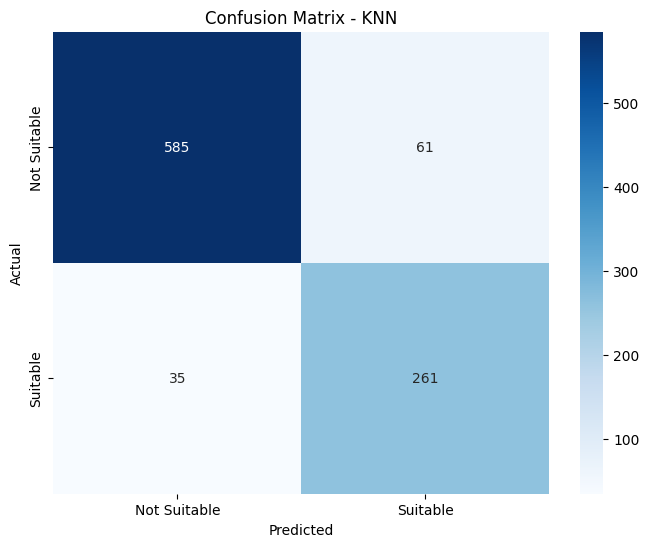

Peringatan: Total Serat (20.90) kurang dari batas minimal harian (29.60 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Serat yang masuk ke dalam tubuh.
Peringatan: Total LemakJenuh (8.35) kurang dari batas minimal harian (12.00 atau 40% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah LemakJenuh yang masuk ke dalam tubuh.
Peringatan: Total Kalsium (506.00) kurang dari batas minimal harian (800.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalsium yang masuk ke dalam tubuh.
Peringatan: Total Kalium (2378.00) kurang dari batas minimal harian (3760.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalium yang masuk ke dalam tubuh.

========== REKOMENDASI MAKANAN ==========

----- Sarapan: Makanan Utama -----

Nama Makanan: Mcdonald's Salad Sisi
Jenis Makanan (Kategori): Makanan Cepat Saji
Energi: 20.00 kkal
Protein: 1.03 g
Serat: 1.60 g
Gula Total: 2.24 g
Lemak Jenuh: 0.02 g
Vitamin C: 15.70 mg
Magnesium: 0.00 mg
Nat

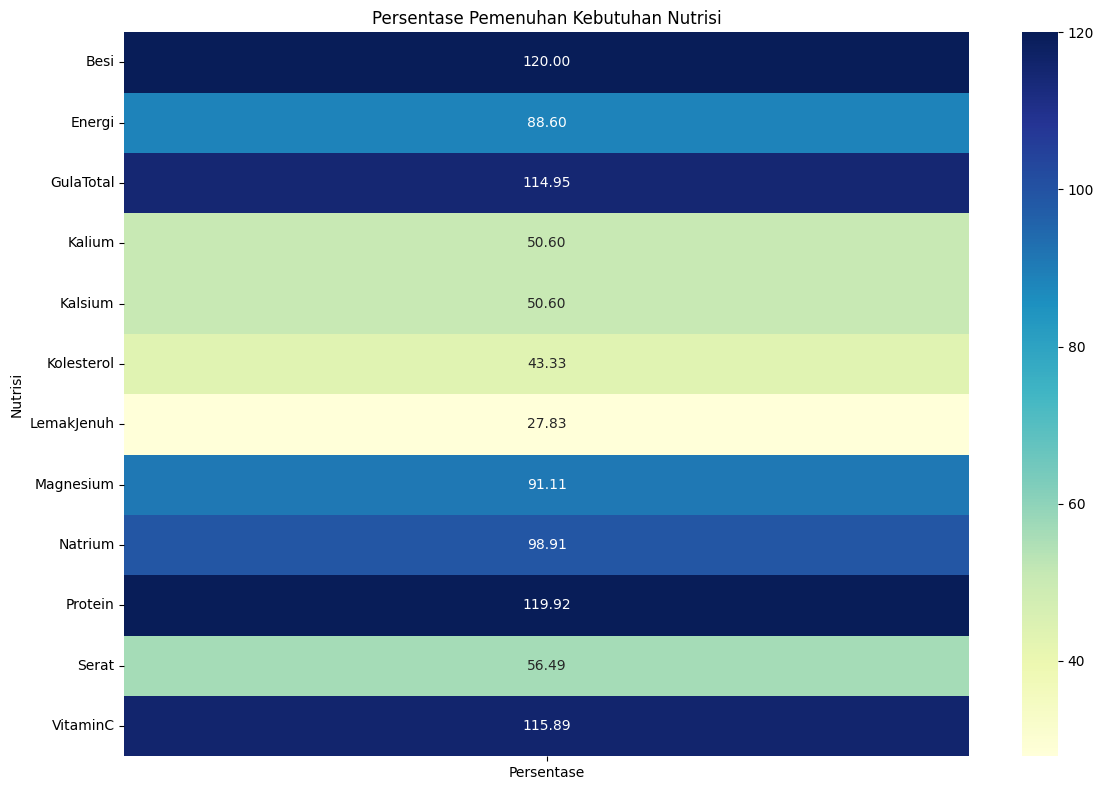

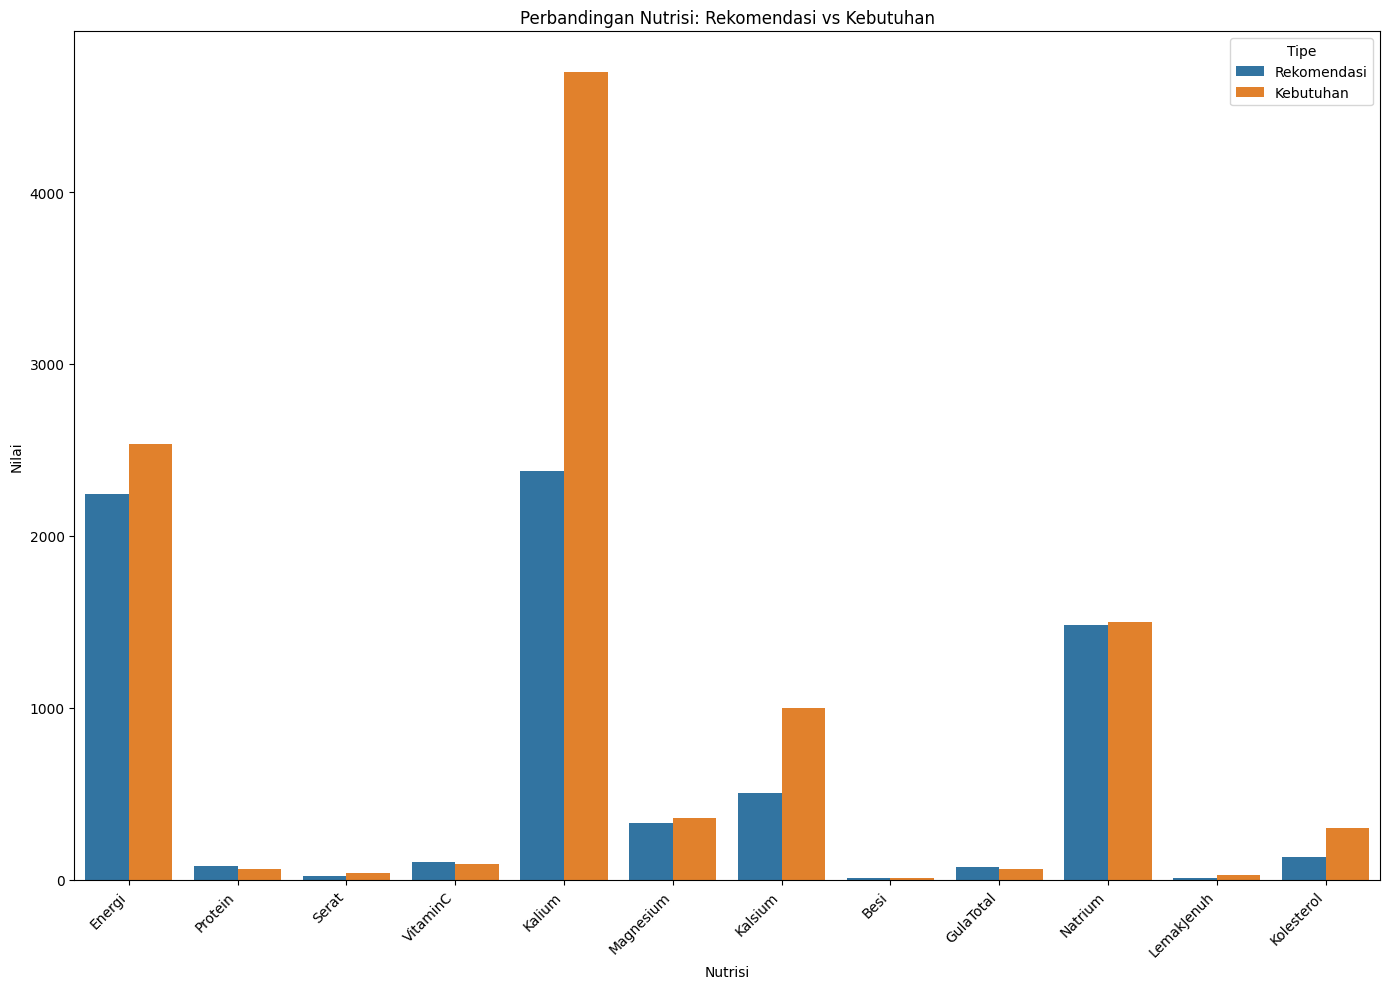


========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========
Energi: 88.60% dari kebutuhan
Protein: 119.92% dari kebutuhan
Serat: 56.49% dari kebutuhan
VitaminC: 115.89% dari kebutuhan
Kalium: 50.60% dari kebutuhan
Magnesium: 91.11% dari kebutuhan
Kalsium: 50.60% dari kebutuhan
Besi: 120.00% dari kebutuhan
GulaTotal: 114.95% dari kebutuhan
Natrium: 98.91% dari kebutuhan
LemakJenuh: 27.83% dari kebutuhan
Kolesterol: 43.33% dari kebutuhan


In [ ]:
def main():
    # Memuat data
    github_url = "https://raw.githubusercontent.com/bachtiarrizkyal/TugasAkhir/refs/heads/main/USDAnew.xlsx"
    df_usda = pd.read_excel(github_url)

    # Melakukan preprocessing data
    df_preprocessed, scaler, df_original, nutrient_cols = preprocess_data(df_usda)

    # Memproses data pengguna (contoh)
    gender = 'laki-laki'
    age = 22
    height = 170
    weight = 75
    diseases = []
    preferred_category = ''

    user_info = process_user_data(gender, age, height, weight, diseases, preferred_category)

    # Tampilkan informasi pengguna
    display_user_info(user_info)

    # Menyiapkan data makanan
    df_labeled, df_main, df_side, df_drink_fruit = prepare_food_data(df_preprocessed, user_info, df_original)

    # Melatih model KNN
    knn, X, y, X_train, X_test, y_train, y_test = train_knn_model(df_labeled, user_info)

    # Evaluasi model
    evaluation = evaluate_model(knn, X_test, y_test)

    print("\n========== EVALUASI MODEL ==========")
    print(f"Accuracy: {evaluation['accuracy']:.4f}")
    print(f"Precision: {evaluation['precision']:.4f}")
    print(f"Recall: {evaluation['recall']:.4f}")
    print(f"True Positive (TP): {evaluation['tp']}")
    print(f"False Positive (FP): {evaluation['fp']}")
    print(f"False Negative (FN): {evaluation['fn']}")
    print(f"True Negative (TN): {evaluation['tn']}")

    # Visualisasi confusion matrix
    visualize_confusion_matrix(evaluation['confusion_matrix'])

    # Rekomendasi makanan dengan Fractional Knapsack
    # Pastikan get_recommendation menggunakan preferred_category dari user_info
    recommended_df = get_recommendation(knn, df_labeled, user_info, df_original)

    # Tampilkan rekomendasi
    display_food_recommendations(recommended_df)

    # Visualisasi perbandingan nutrisi
    comparison = visualize_nutrition_comparison(recommended_df, user_info)

    # Tampilkan persentase pemenuhan nutrisi
    print("\n========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========")
    for _, row in comparison.iterrows():
        print(f"{row['Nutrisi']}: {row['Persentase']:.2f}% dari kebutuhan")

if __name__ == "__main__":
    main()

## **DIABETES**


========== PROFIL PENGGUNA ==========
Jenis Kelamin: Laki-laki
Usia: 22 tahun (dewasa)
Tinggi Badan: 170 cm
Berat Badan: 75 kg
Riwayat Penyakit: Diabetes
Preferensi Makanan: Produk panggang

========== INFORMASI KESEHATAN ==========
BMI: 25.95
Kategori BMI: Berat Badan Berlebih (Overweight)
Berat Badan Ideal: 63.00 kg
Kebutuhan Energi: 2533.88 kkal

========== KEBUTUHAN NUTRISI ==========
Energi: 2533.88 kkal
Protein: 126.69 g
Serat: 42.55 g
Gula Total: 31.67 g
Lemak Jenuh: 19.71 g
Vitamin C: 103.50 mg
Magnesium: 360.00 mg
Natrium: 1275.00 mg
Kalsium: 1000.00 mg
Kalium: 4700.00 mg
Besi: 9.00 mg
Kolesterol: 200.00 mg
Fitting 5 folds for each of 7 candidates, totalling 35 fits

--- Hasil Tuning KNN ---
Hyperparameter terbaik (berdasarkan recall): {'metric': 'euclidean', 'n_neighbors': 3}
Nilai recall terbaik pada cross-validation: 0.7153
Akurasi terbaik pada test set: 0.9151
Precision terbaik pada test set: 0.7452
Recall terbaik pada test set: 0.7452

========== EVALUASI MODEL =========

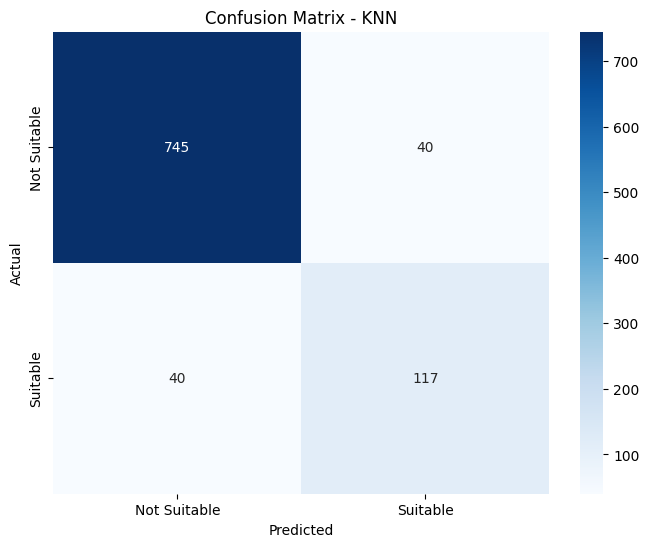

Makanan dari kategori favorit 'Produk Panggang' berhasil ditambahkan pada waktu makan: Sarapan (Makanan Pendamping).
Peringatan: Total energi (1473.00 kkal) kurang dari batas minimal harian (2027.10 kkal atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah kalori yang masuk ke dalam tubuh.
Peringatan: Total GulaTotal (18.38) kurang dari batas minimal harian (19.00 atau 60% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah GulaTotal yang masuk ke dalam tubuh.
Peringatan: Total Serat (31.40) kurang dari batas minimal harian (34.04 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Serat yang masuk ke dalam tubuh.
Peringatan: Total LemakJenuh (3.34) kurang dari batas minimal harian (7.88 atau 40% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah LemakJenuh yang masuk ke dalam tubuh.
Peringatan: Total Kalsium (262.00) kurang dari batas minimal harian (800.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalsium yang masuk k

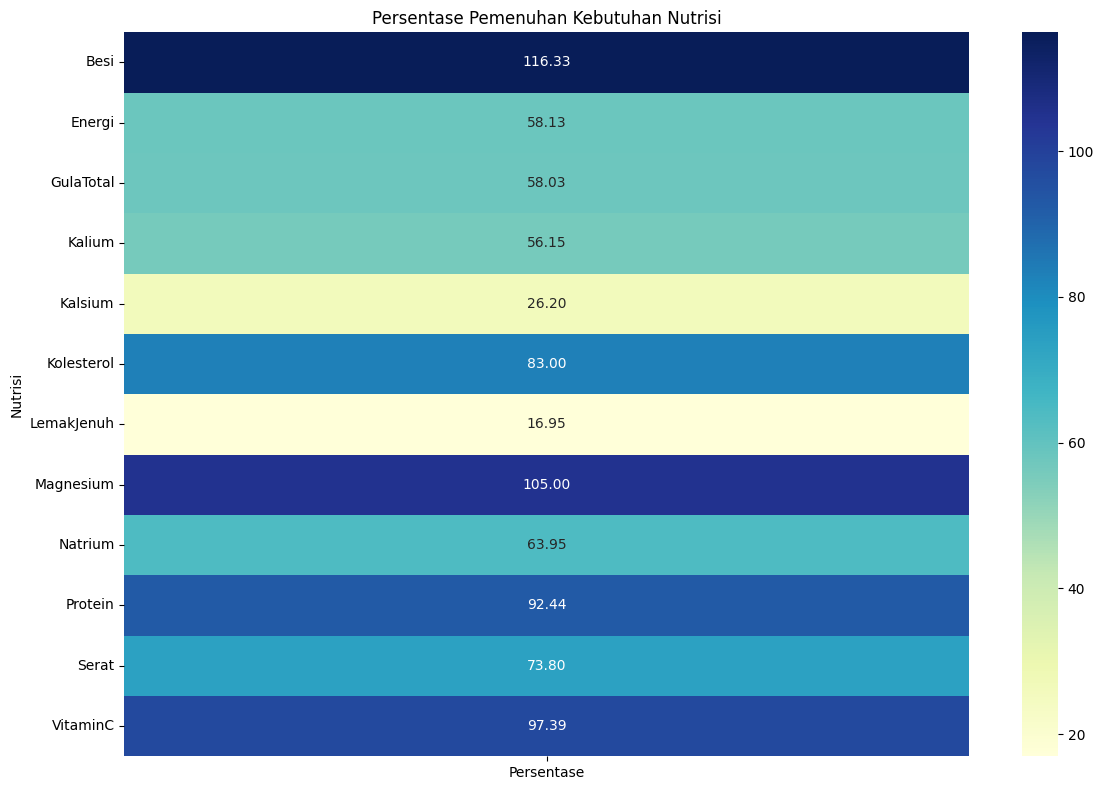

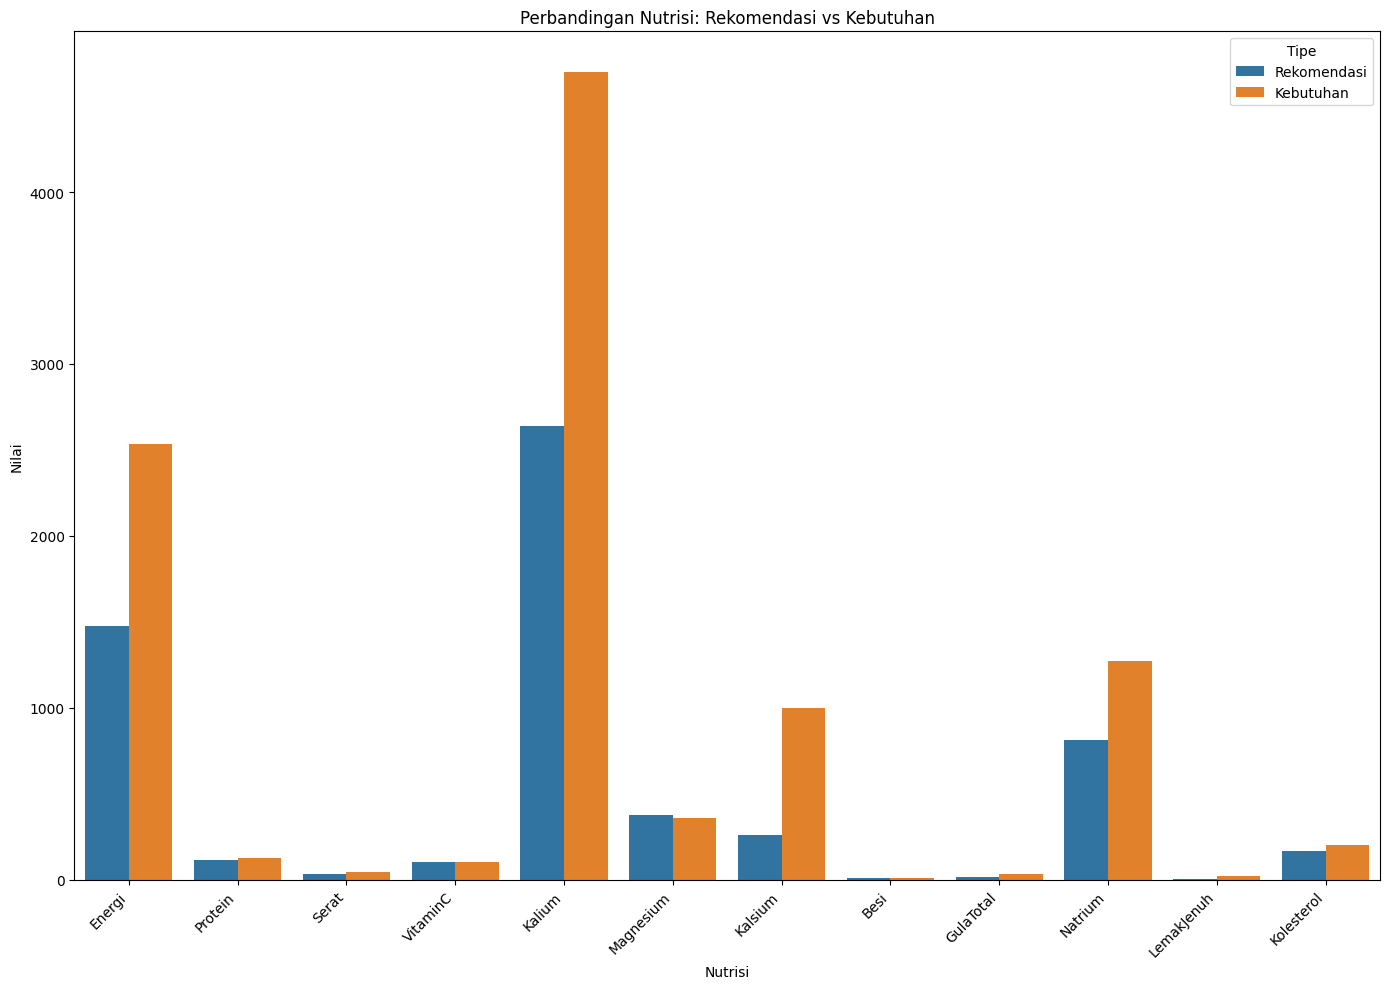


========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========
Energi: 58.13% dari kebutuhan
Protein: 92.44% dari kebutuhan
Serat: 73.80% dari kebutuhan
VitaminC: 97.39% dari kebutuhan
Kalium: 56.15% dari kebutuhan
Magnesium: 105.00% dari kebutuhan
Kalsium: 26.20% dari kebutuhan
Besi: 116.33% dari kebutuhan
GulaTotal: 58.03% dari kebutuhan
Natrium: 63.95% dari kebutuhan
LemakJenuh: 16.95% dari kebutuhan
Kolesterol: 83.00% dari kebutuhan


In [ ]:
def main():
    # Memuat data
    github_url = "https://raw.githubusercontent.com/bachtiarrizkyal/TugasAkhir/refs/heads/main/USDAnew.xlsx"
    df_usda = pd.read_excel(github_url)

    # Melakukan preprocessing data
    df_preprocessed, scaler, df_original, nutrient_cols = preprocess_data(df_usda)

    # Memproses data pengguna (contoh)
    gender = 'laki-laki'
    age = 22
    height = 170
    weight = 75
    diseases = ['diabetes']
    preferred_category = 'Produk Panggang'

    user_info = process_user_data(gender, age, height, weight, diseases, preferred_category)

    # Tampilkan informasi pengguna
    display_user_info(user_info)

    # Menyiapkan data makanan
    df_labeled, df_main, df_side, df_drink_fruit = prepare_food_data(df_preprocessed, user_info, df_original)

    # Melatih model KNN
    knn, X, y, X_train, X_test, y_train, y_test = train_knn_model(df_labeled, user_info)

    # Evaluasi model
    evaluation = evaluate_model(knn, X_test, y_test)

    print("\n========== EVALUASI MODEL ==========")
    print(f"Accuracy: {evaluation['accuracy']:.4f}")
    print(f"Precision: {evaluation['precision']:.4f}")
    print(f"Recall: {evaluation['recall']:.4f}")
    print(f"True Positive (TP): {evaluation['tp']}")
    print(f"False Positive (FP): {evaluation['fp']}")
    print(f"False Negative (FN): {evaluation['fn']}")
    print(f"True Negative (TN): {evaluation['tn']}")

    # Visualisasi confusion matrix
    visualize_confusion_matrix(evaluation['confusion_matrix'])

    # Rekomendasi makanan dengan Fractional Knapsack
    recommended_df = get_recommendation(knn, df_labeled, user_info, df_original)

    # Tampilkan rekomendasi
    display_food_recommendations(recommended_df)

    # Visualisasi perbandingan nutrisi
    comparison = visualize_nutrition_comparison(recommended_df, user_info)

    # Tampilkan persentase pemenuhan nutrisi
    print("\n========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========")
    for _, row in comparison.iterrows():
        print(f"{row['Nutrisi']}: {row['Persentase']:.2f}% dari kebutuhan")

if __name__ == "__main__":
    main()

## **HIPERTENSI**


========== PROFIL PENGGUNA ==========
Jenis Kelamin: Laki-laki
Usia: 22 tahun (dewasa)
Tinggi Badan: 170 cm
Berat Badan: 75 kg
Riwayat Penyakit: Hipertensi
Preferensi Makanan: Tidak Ada/Tidak Ditentukan

========== INFORMASI KESEHATAN ==========
BMI: 25.95
Kategori BMI: Berat Badan Berlebih (Overweight)
Berat Badan Ideal: 63.00 kg
Kebutuhan Energi: 2533.88 kkal

========== KEBUTUHAN NUTRISI ==========
Energi: 2533.88 kkal
Protein: 65.00 g
Serat: 42.55 g
Gula Total: 63.35 g
Lemak Jenuh: 19.71 g
Vitamin C: 90.00 mg
Magnesium: 414.00 mg
Natrium: 1275.00 mg
Kalsium: 1150.00 mg
Kalium: 5405.00 mg
Besi: 9.00 mg
Kolesterol: 200.00 mg
Fitting 5 folds for each of 7 candidates, totalling 35 fits

--- Hasil Tuning KNN ---
Hyperparameter terbaik (berdasarkan recall): {'metric': 'euclidean', 'n_neighbors': 3}
Nilai recall terbaik pada cross-validation: 0.7883
Akurasi terbaik pada test set: 0.9289
Precision terbaik pada test set: 0.7798
Recall terbaik pada test set: 0.8137

========== EVALUASI MODE

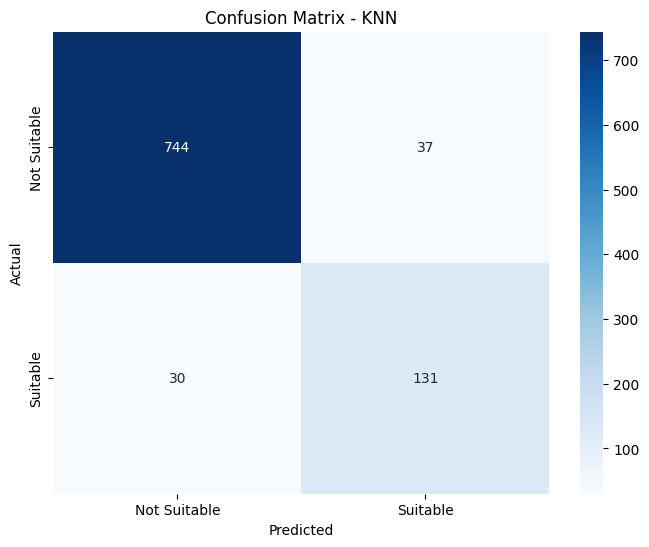

Peringatan: Total energi (1004.00 kkal) kurang dari batas minimal harian (2027.10 kkal atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah kalori yang masuk ke dalam tubuh.
Peringatan: Total GulaTotal (4.32) kurang dari batas minimal harian (38.01 atau 60% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah GulaTotal yang masuk ke dalam tubuh.
Peringatan: Total Serat (23.30) kurang dari batas minimal harian (34.04 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Serat yang masuk ke dalam tubuh.
Peringatan: Total LemakJenuh (2.43) kurang dari batas minimal harian (7.88 atau 40% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah LemakJenuh yang masuk ke dalam tubuh.
Peringatan: Total Natrium (649.27) kurang dari batas minimal harian (765.00 atau 60% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Natrium yang masuk ke dalam tubuh.
Peringatan: Total Kalsium (261.00) kurang dari batas minimal harian (920.00 atau 80% dari kebutuhan). T

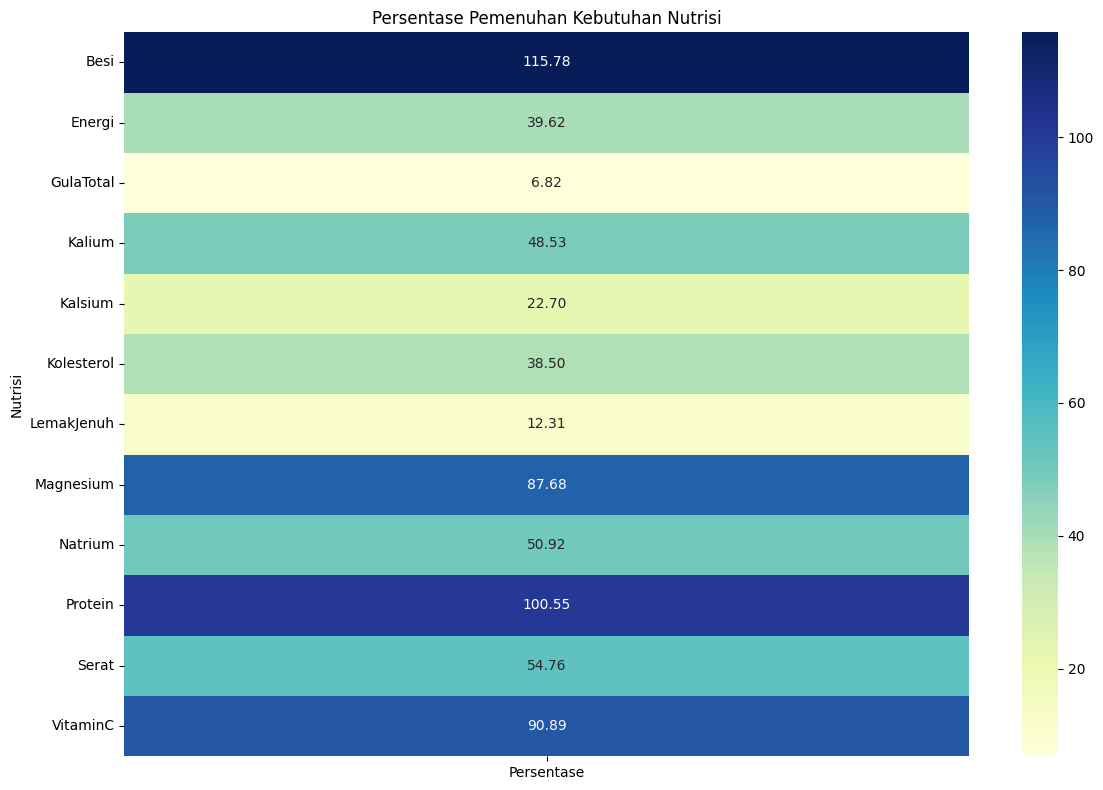

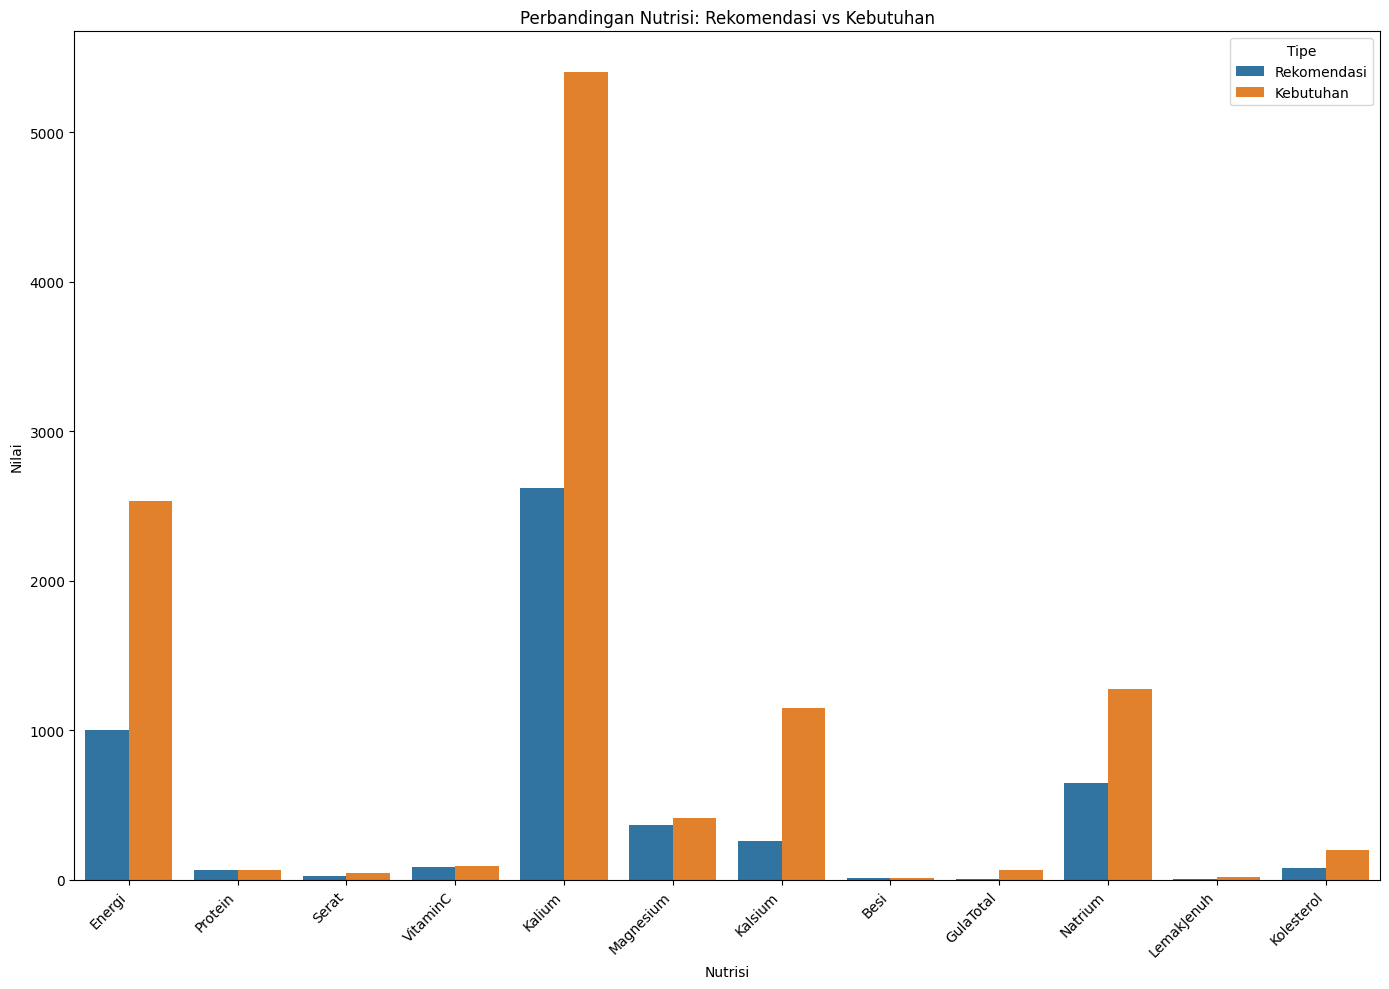


========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========
Energi: 39.62% dari kebutuhan
Protein: 100.55% dari kebutuhan
Serat: 54.76% dari kebutuhan
VitaminC: 90.89% dari kebutuhan
Kalium: 48.53% dari kebutuhan
Magnesium: 87.68% dari kebutuhan
Kalsium: 22.70% dari kebutuhan
Besi: 115.78% dari kebutuhan
GulaTotal: 6.82% dari kebutuhan
Natrium: 50.92% dari kebutuhan
LemakJenuh: 12.31% dari kebutuhan
Kolesterol: 38.50% dari kebutuhan


In [ ]:
def main():
    # Memuat data
    github_url = "https://raw.githubusercontent.com/bachtiarrizkyal/TugasAkhir/refs/heads/main/USDAnew.xlsx"
    df_usda = pd.read_excel(github_url)

    # Melakukan preprocessing data
    df_preprocessed, scaler, df_original, nutrient_cols = preprocess_data(df_usda)

    # Memproses data pengguna (contoh)
    gender = 'laki-laki'
    age = 22
    height = 170
    weight = 75
    diseases = ['hipertensi']

    user_info = process_user_data(gender, age, height, weight, diseases)

    # Tampilkan informasi pengguna
    display_user_info(user_info)

    # Menyiapkan data makanan
    df_labeled, df_main, df_side, df_drink_fruit = prepare_food_data(df_preprocessed, user_info, df_original)

    # Melatih model KNN
    knn, X, y, X_train, X_test, y_train, y_test = train_knn_model(df_labeled, user_info)

    # Evaluasi model
    evaluation = evaluate_model(knn, X_test, y_test)

    print("\n========== EVALUASI MODEL ==========")
    print(f"Accuracy: {evaluation['accuracy']:.4f}")
    print(f"Precision: {evaluation['precision']:.4f}")
    print(f"Recall: {evaluation['recall']:.4f}")
    print(f"True Positive (TP): {evaluation['tp']}")
    print(f"False Positive (FP): {evaluation['fp']}")
    print(f"False Negative (FN): {evaluation['fn']}")
    print(f"True Negative (TN): {evaluation['tn']}")

    # Visualisasi confusion matrix
    visualize_confusion_matrix(evaluation['confusion_matrix'])

    # Rekomendasi makanan dengan Fractional Knapsack
    recommended_df = get_recommendation(knn, df_labeled, user_info, df_original)

    # Tampilkan rekomendasi
    display_food_recommendations(recommended_df)

    # Visualisasi perbandingan nutrisi
    comparison = visualize_nutrition_comparison(recommended_df, user_info)

    # Tampilkan persentase pemenuhan nutrisi
    print("\n========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========")
    for _, row in comparison.iterrows():
        print(f"{row['Nutrisi']}: {row['Persentase']:.2f}% dari kebutuhan")

if __name__ == "__main__":
    main()

## **CARDIOVASCULAR DISEASE**


========== PROFIL PENGGUNA ==========
Jenis Kelamin: Laki-laki
Usia: 22 tahun (dewasa)
Tinggi Badan: 170 cm
Berat Badan: 75 kg
Riwayat Penyakit: Cardiovascular disease
Preferensi Makanan: Produk panggang

========== INFORMASI KESEHATAN ==========
BMI: 25.95
Kategori BMI: Berat Badan Berlebih (Overweight)
Berat Badan Ideal: 63.00 kg
Kebutuhan Energi: 2533.88 kkal

========== KEBUTUHAN NUTRISI ==========
Energi: 2533.88 kkal
Protein: 126.69 g
Serat: 42.55 g
Gula Total: 63.35 g
Lemak Jenuh: 19.71 g
Vitamin C: 90.00 mg
Magnesium: 360.00 mg
Natrium: 1275.00 mg
Kalsium: 1000.00 mg
Kalium: 4700.00 mg
Besi: 10.35 mg
Kolesterol: 200.00 mg
Fitting 5 folds for each of 7 candidates, totalling 35 fits

--- Hasil Tuning KNN ---
Hyperparameter terbaik (berdasarkan recall): {'metric': 'euclidean', 'n_neighbors': 3}
Nilai recall terbaik pada cross-validation: 0.8233
Akurasi terbaik pada test set: 0.9098
Precision terbaik pada test set: 0.7512
Recall terbaik pada test set: 0.8402

========== EVALUASI M

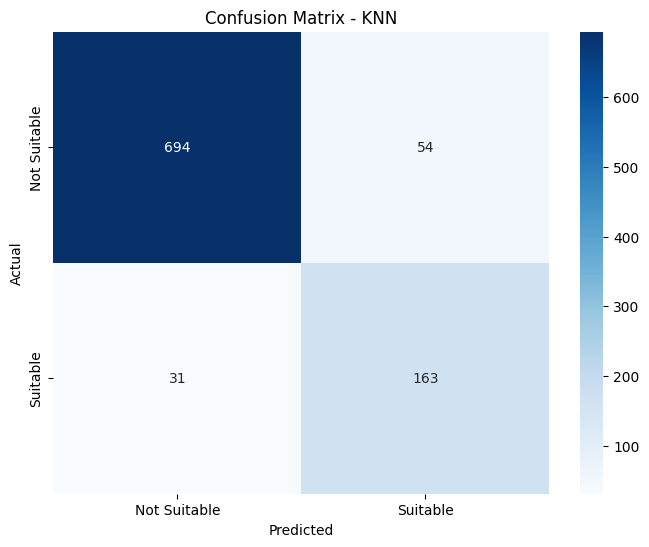

Makanan dari kategori favorit 'Produk Panggang' berhasil ditambahkan pada waktu makan: Sarapan (Makanan Pendamping).
Peringatan: Total GulaTotal (26.81) kurang dari batas minimal harian (38.01 atau 60% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah GulaTotal yang masuk ke dalam tubuh.
Peringatan: Total VitaminC (68.00) kurang dari batas minimal harian (72.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah VitaminC yang masuk ke dalam tubuh.
Peringatan: Total Natrium (587.43) kurang dari batas minimal harian (765.00 atau 60% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Natrium yang masuk ke dalam tubuh.
Peringatan: Total Kalsium (272.00) kurang dari batas minimal harian (800.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalsium yang masuk ke dalam tubuh.
Peringatan: Total Kalium (2595.00) kurang dari batas minimal harian (3760.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalium yang masuk ke dala

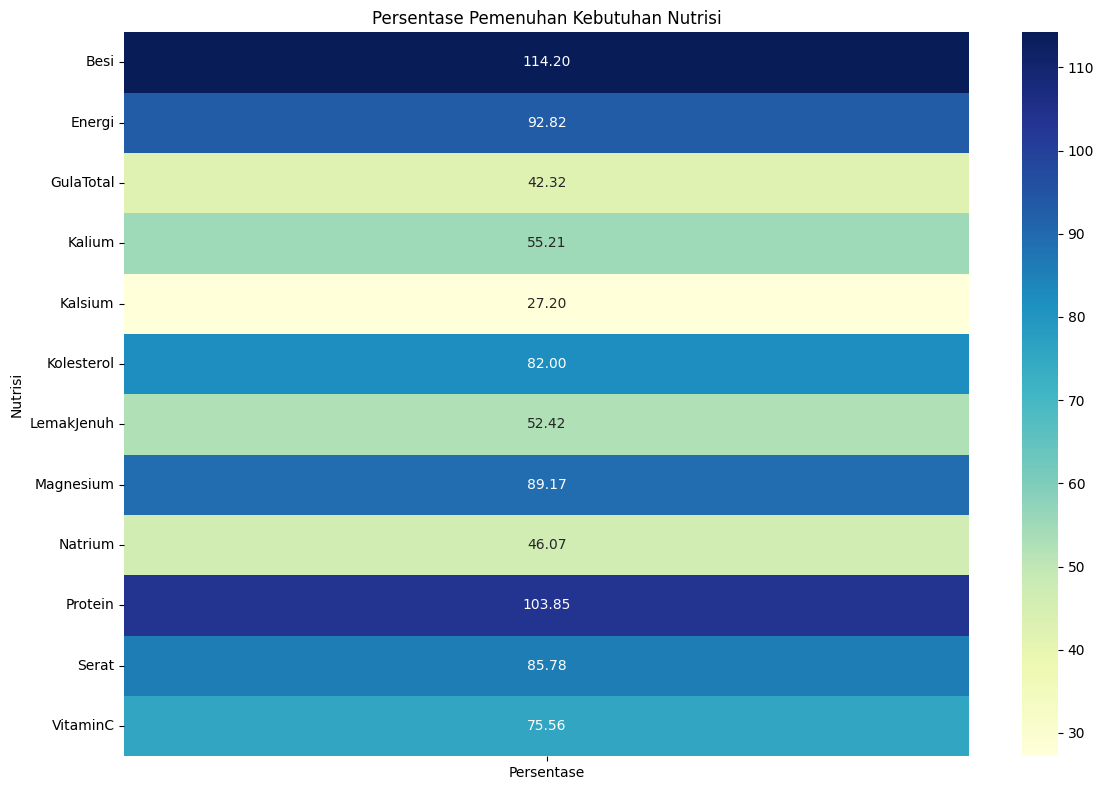

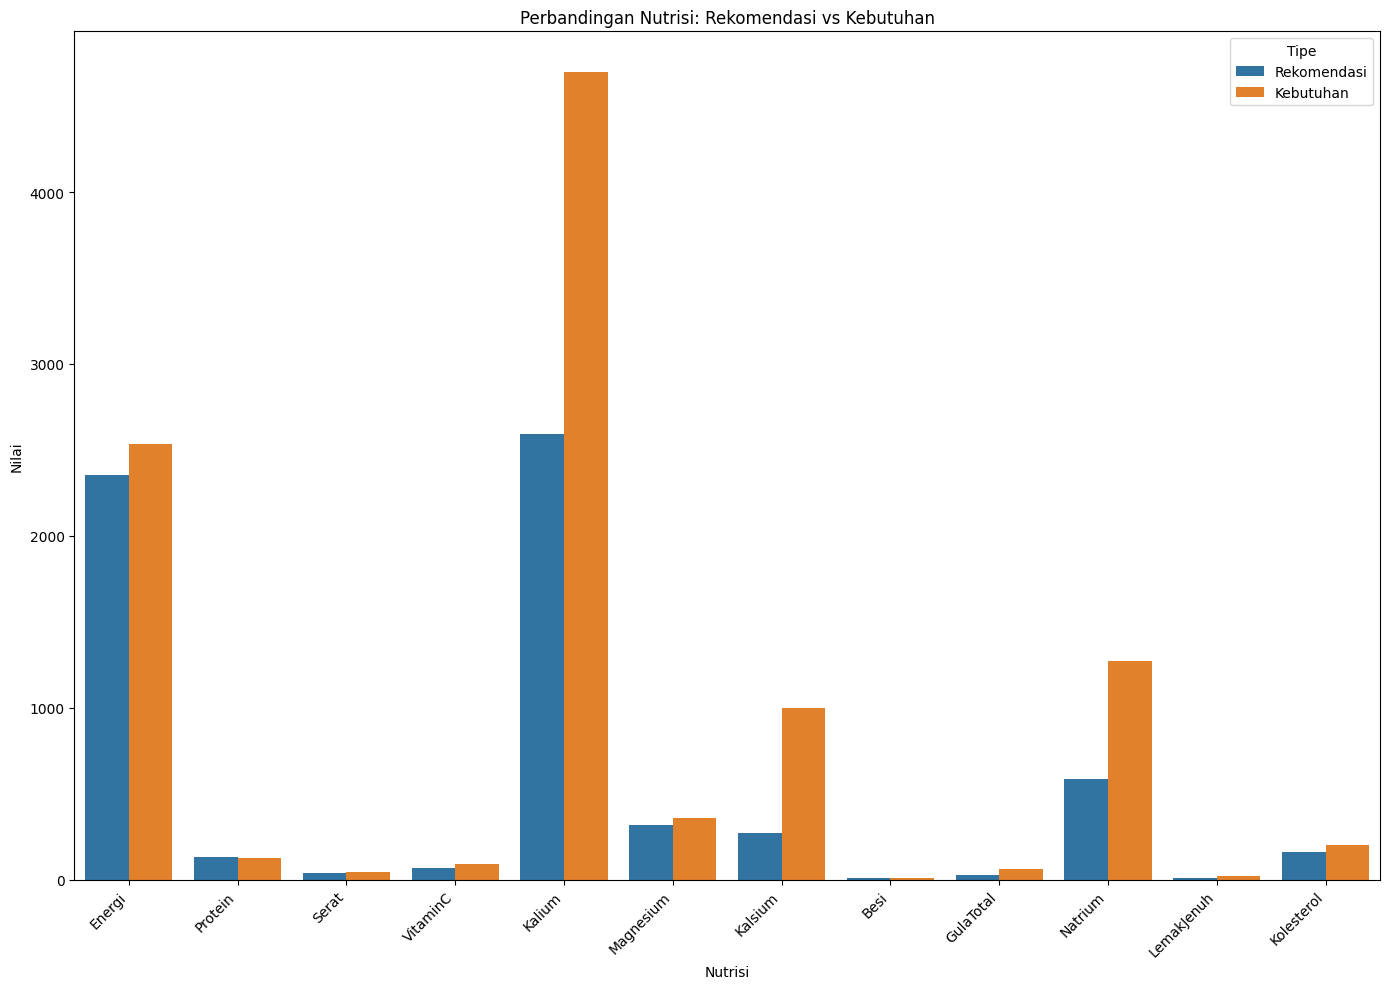


========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========
Energi: 92.82% dari kebutuhan
Protein: 103.85% dari kebutuhan
Serat: 85.78% dari kebutuhan
VitaminC: 75.56% dari kebutuhan
Kalium: 55.21% dari kebutuhan
Magnesium: 89.17% dari kebutuhan
Kalsium: 27.20% dari kebutuhan
Besi: 114.20% dari kebutuhan
GulaTotal: 42.32% dari kebutuhan
Natrium: 46.07% dari kebutuhan
LemakJenuh: 52.42% dari kebutuhan
Kolesterol: 82.00% dari kebutuhan


In [ ]:
def main():
    # Memuat data
    github_url = "https://raw.githubusercontent.com/bachtiarrizkyal/TugasAkhir/refs/heads/main/USDAnew.xlsx"
    df_usda = pd.read_excel(github_url)

    # Melakukan preprocessing data
    df_preprocessed, scaler, df_original, nutrient_cols = preprocess_data(df_usda)

    # Memproses data pengguna (contoh)
    gender = 'laki-laki'
    age = 22
    height = 170
    weight = 75
    diseases = ['cardiovascular disease']
    preferred_category = 'Produk Panggang'

    user_info = process_user_data(gender, age, height, weight, diseases, preferred_category)

    # Tampilkan informasi pengguna
    display_user_info(user_info)

    # Menyiapkan data makanan
    df_labeled, df_main, df_side, df_drink_fruit = prepare_food_data(df_preprocessed, user_info, df_original)

    # Melatih model KNN
    knn, X, y, X_train, X_test, y_train, y_test = train_knn_model(df_labeled, user_info)

    # Evaluasi model
    evaluation = evaluate_model(knn, X_test, y_test)

    print("\n========== EVALUASI MODEL ==========")
    print(f"Accuracy: {evaluation['accuracy']:.4f}")
    print(f"Precision: {evaluation['precision']:.4f}")
    print(f"Recall: {evaluation['recall']:.4f}")
    print(f"True Positive (TP): {evaluation['tp']}")
    print(f"False Positive (FP): {evaluation['fp']}")
    print(f"False Negative (FN): {evaluation['fn']}")
    print(f"True Negative (TN): {evaluation['tn']}")

    # Visualisasi confusion matrix
    visualize_confusion_matrix(evaluation['confusion_matrix'])

    # Rekomendasi makanan dengan Fractional Knapsack
    recommended_df = get_recommendation(knn, df_labeled, user_info, df_original)

    # Tampilkan rekomendasi
    display_food_recommendations(recommended_df)

    # Visualisasi perbandingan nutrisi
    comparison = visualize_nutrition_comparison(recommended_df, user_info)

    # Tampilkan persentase pemenuhan nutrisi
    print("\n========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========")
    for _, row in comparison.iterrows():
        print(f"{row['Nutrisi']}: {row['Persentase']:.2f}% dari kebutuhan")

if __name__ == "__main__":
    main()

## **DIABETES dan HIPERTENSI**


========== PROFIL PENGGUNA ==========
Jenis Kelamin: Laki-laki
Usia: 22 tahun (dewasa)
Tinggi Badan: 170 cm
Berat Badan: 75 kg
Riwayat Penyakit: Diabetes, Hipertensi
Preferensi Makanan: Tidak Ada/Tidak Ditentukan

========== INFORMASI KESEHATAN ==========
BMI: 25.95
Kategori BMI: Berat Badan Berlebih (Overweight)
Berat Badan Ideal: 63.00 kg
Kebutuhan Energi: 2533.88 kkal

========== KEBUTUHAN NUTRISI ==========
Energi: 2533.88 kkal
Protein: 126.69 g
Serat: 42.55 g
Gula Total: 31.67 g
Lemak Jenuh: 19.71 g
Vitamin C: 103.50 mg
Magnesium: 414.00 mg
Natrium: 1275.00 mg
Kalsium: 1150.00 mg
Kalium: 5405.00 mg
Besi: 9.00 mg
Kolesterol: 200.00 mg
Fitting 5 folds for each of 7 candidates, totalling 35 fits

--- Hasil Tuning KNN ---
Hyperparameter terbaik (berdasarkan recall): {'metric': 'euclidean', 'n_neighbors': 3}
Nilai recall terbaik pada cross-validation: 0.7327
Akurasi terbaik pada test set: 0.9098
Precision terbaik pada test set: 0.7566
Recall terbaik pada test set: 0.7857

========== E

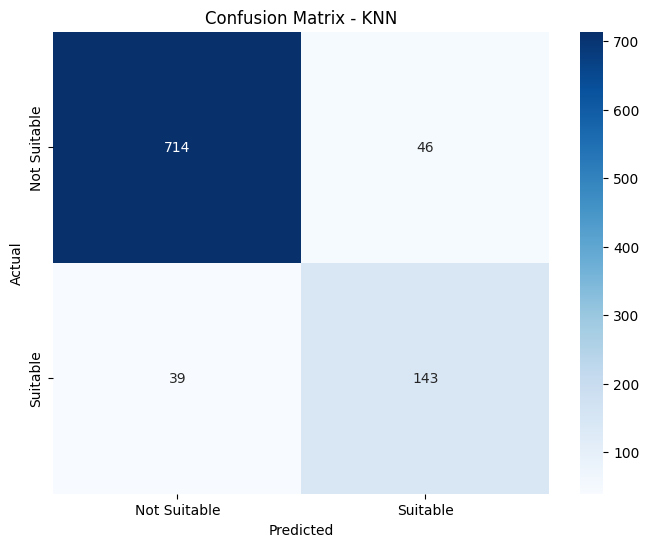

Peringatan: Total energi (965.00 kkal) kurang dari batas minimal harian (2027.10 kkal atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah kalori yang masuk ke dalam tubuh.
Peringatan: Total GulaTotal (17.49) kurang dari batas minimal harian (19.00 atau 60% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah GulaTotal yang masuk ke dalam tubuh.
Peringatan: Total Serat (13.70) kurang dari batas minimal harian (34.04 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Serat yang masuk ke dalam tubuh.
Peringatan: Total Protein (89.15) kurang dari batas minimal harian (101.36 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Protein yang masuk ke dalam tubuh.
Peringatan: Total LemakJenuh (5.76) kurang dari batas minimal harian (7.88 atau 40% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah LemakJenuh yang masuk ke dalam tubuh.
Peringatan: Total Magnesium (270.00) kurang dari batas minimal harian (331.20 atau 80% dari kebutuhan). 

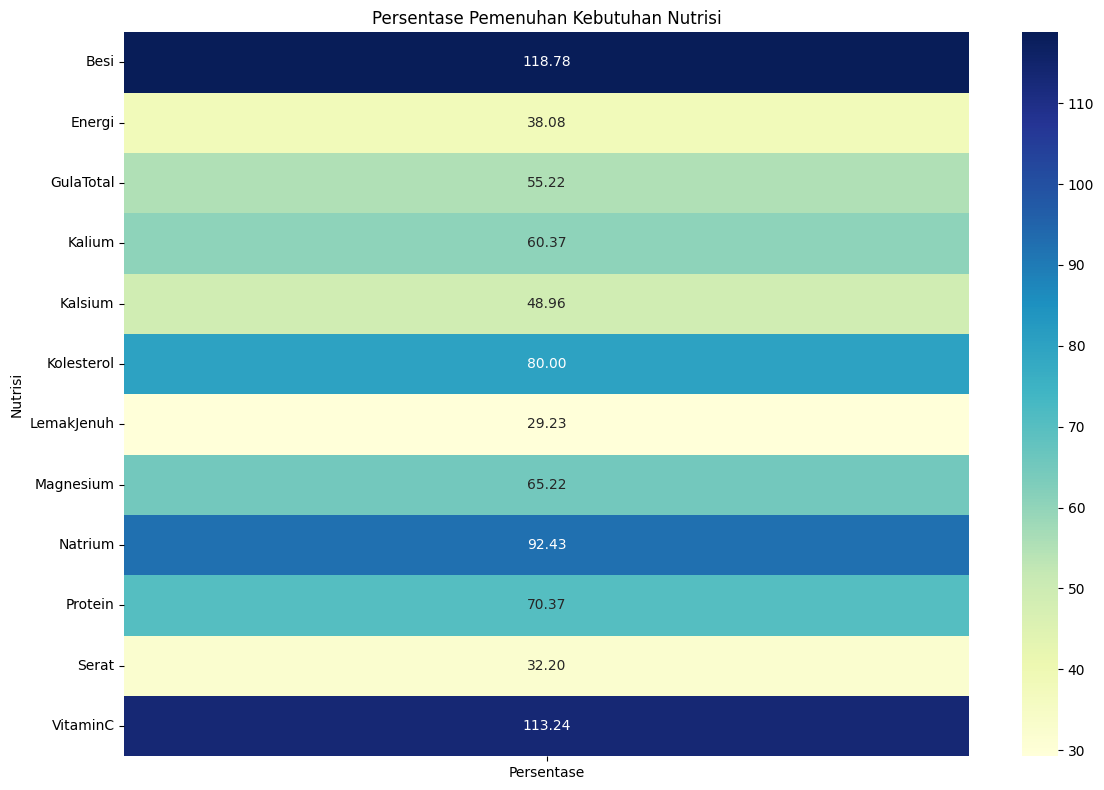

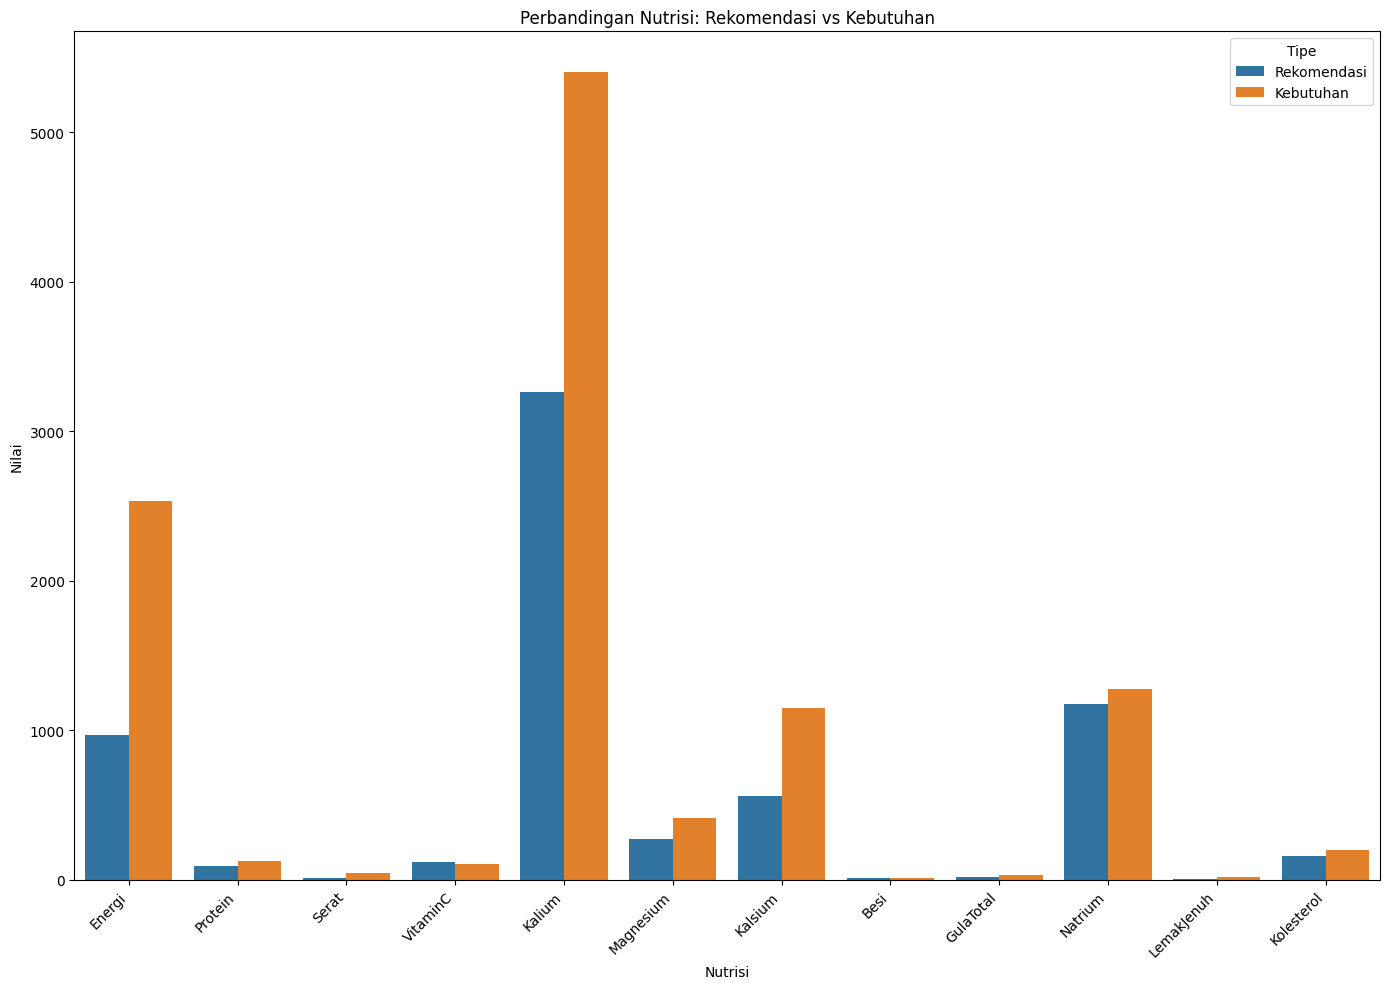


========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========
Energi: 38.08% dari kebutuhan
Protein: 70.37% dari kebutuhan
Serat: 32.20% dari kebutuhan
VitaminC: 113.24% dari kebutuhan
Kalium: 60.37% dari kebutuhan
Magnesium: 65.22% dari kebutuhan
Kalsium: 48.96% dari kebutuhan
Besi: 118.78% dari kebutuhan
GulaTotal: 55.22% dari kebutuhan
Natrium: 92.43% dari kebutuhan
LemakJenuh: 29.23% dari kebutuhan
Kolesterol: 80.00% dari kebutuhan


In [ ]:
def main():
    # Memuat data
    github_url = "https://raw.githubusercontent.com/bachtiarrizkyal/TugasAkhir/refs/heads/main/USDA.xlsx"
    df_usda = pd.read_excel(github_url)

    # Melakukan preprocessing data
    df_preprocessed, scaler, df_original, nutrient_cols = preprocess_data(df_usda)

    # Memproses data pengguna (contoh)
    gender = 'laki-laki'
    age = 22
    height = 170
    weight = 75
    diseases = ['diabetes', 'hipertensi']

    user_info = process_user_data(gender, age, height, weight, diseases)

    # Tampilkan informasi pengguna
    display_user_info(user_info)

    # Menyiapkan data makanan
    df_labeled, df_main, df_side, df_drink_fruit = prepare_food_data(df_preprocessed, user_info, df_original)

    # Melatih model KNN
    knn, X, y, X_train, X_test, y_train, y_test = train_knn_model(df_labeled, user_info)

    # Evaluasi model
    evaluation = evaluate_model(knn, X_test, y_test)

    print("\n========== EVALUASI MODEL ==========")
    print(f"Accuracy: {evaluation['accuracy']:.4f}")
    print(f"Precision: {evaluation['precision']:.4f}")
    print(f"Recall: {evaluation['recall']:.4f}")
    print(f"True Positive (TP): {evaluation['tp']}")
    print(f"False Positive (FP): {evaluation['fp']}")
    print(f"False Negative (FN): {evaluation['fn']}")
    print(f"True Negative (TN): {evaluation['tn']}")

    # Visualisasi confusion matrix
    visualize_confusion_matrix(evaluation['confusion_matrix'])

    # Rekomendasi makanan dengan Fractional Knapsack
    recommended_df = get_recommendation(knn, df_labeled, user_info, df_original)

    # Tampilkan rekomendasi
    display_food_recommendations(recommended_df)

    # Visualisasi perbandingan nutrisi
    comparison = visualize_nutrition_comparison(recommended_df, user_info)

    # Tampilkan persentase pemenuhan nutrisi
    print("\n========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========")
    for _, row in comparison.iterrows():
        print(f"{row['Nutrisi']}: {row['Persentase']:.2f}% dari kebutuhan")

if __name__ == "__main__":
    main()

## **DIABETES dan CARDIOVASCULAR DISEASE**


========== PROFIL PENGGUNA ==========
Jenis Kelamin: Laki-laki
Usia: 22 tahun (dewasa)
Tinggi Badan: 170 cm
Berat Badan: 75 kg
Riwayat Penyakit: Diabetes, Cardiovascular disease
Preferensi Makanan: Tidak Ada/Tidak Ditentukan

========== INFORMASI KESEHATAN ==========
BMI: 25.95
Kategori BMI: Berat Badan Berlebih (Overweight)
Berat Badan Ideal: 63.00 kg
Kebutuhan Energi: 2533.88 kkal

========== KEBUTUHAN NUTRISI ==========
Energi: 2533.88 kkal
Protein: 126.69 g
Serat: 42.55 g
Gula Total: 31.67 g
Lemak Jenuh: 19.71 g
Vitamin C: 103.50 mg
Magnesium: 360.00 mg
Natrium: 1275.00 mg
Kalsium: 1000.00 mg
Kalium: 4700.00 mg
Besi: 10.35 mg
Kolesterol: 200.00 mg
Fitting 5 folds for each of 7 candidates, totalling 35 fits

--- Hasil Tuning KNN ---
Hyperparameter terbaik (berdasarkan recall): {'metric': 'euclidean', 'n_neighbors': 3}
Nilai recall terbaik pada cross-validation: 0.7447
Akurasi terbaik pada test set: 0.9055
Precision terbaik pada test set: 0.7303
Recall terbaik pada test set: 0.7602


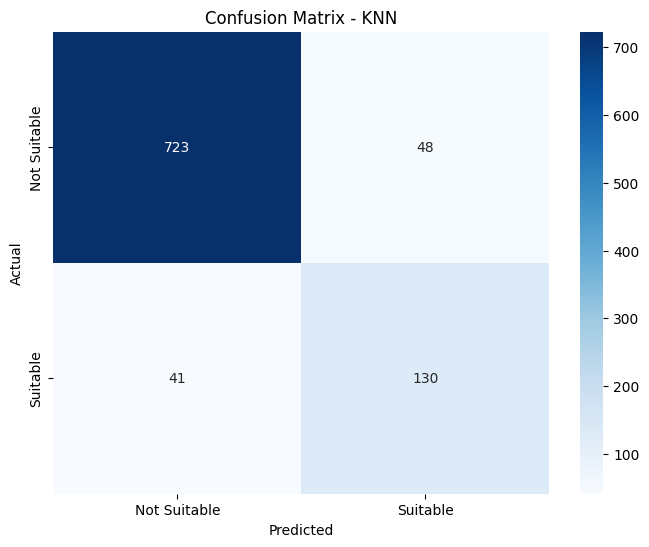

Peringatan: Total Serat (28.90) kurang dari batas minimal harian (34.04 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Serat yang masuk ke dalam tubuh.
Peringatan: Total Magnesium (220.00) kurang dari batas minimal harian (288.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Magnesium yang masuk ke dalam tubuh.
Peringatan: Total Natrium (441.87) kurang dari batas minimal harian (765.00 atau 60% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Natrium yang masuk ke dalam tubuh.
Peringatan: Total Kalsium (134.00) kurang dari batas minimal harian (800.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalsium yang masuk ke dalam tubuh.
Peringatan: Total Kalium (2483.00) kurang dari batas minimal harian (3760.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalium yang masuk ke dalam tubuh.

========== REKOMENDASI MAKANAN ==========

----- Sarapan: Makanan Utama -----

Nama Makanan: Pastrami daging sa

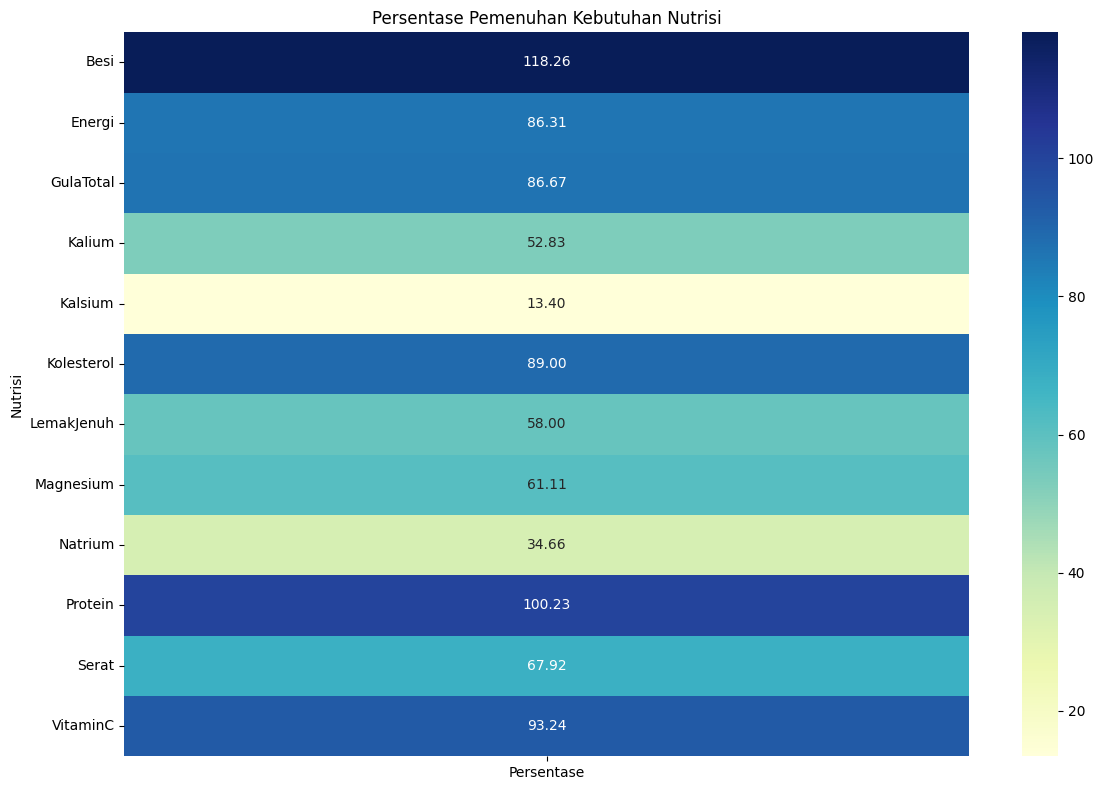

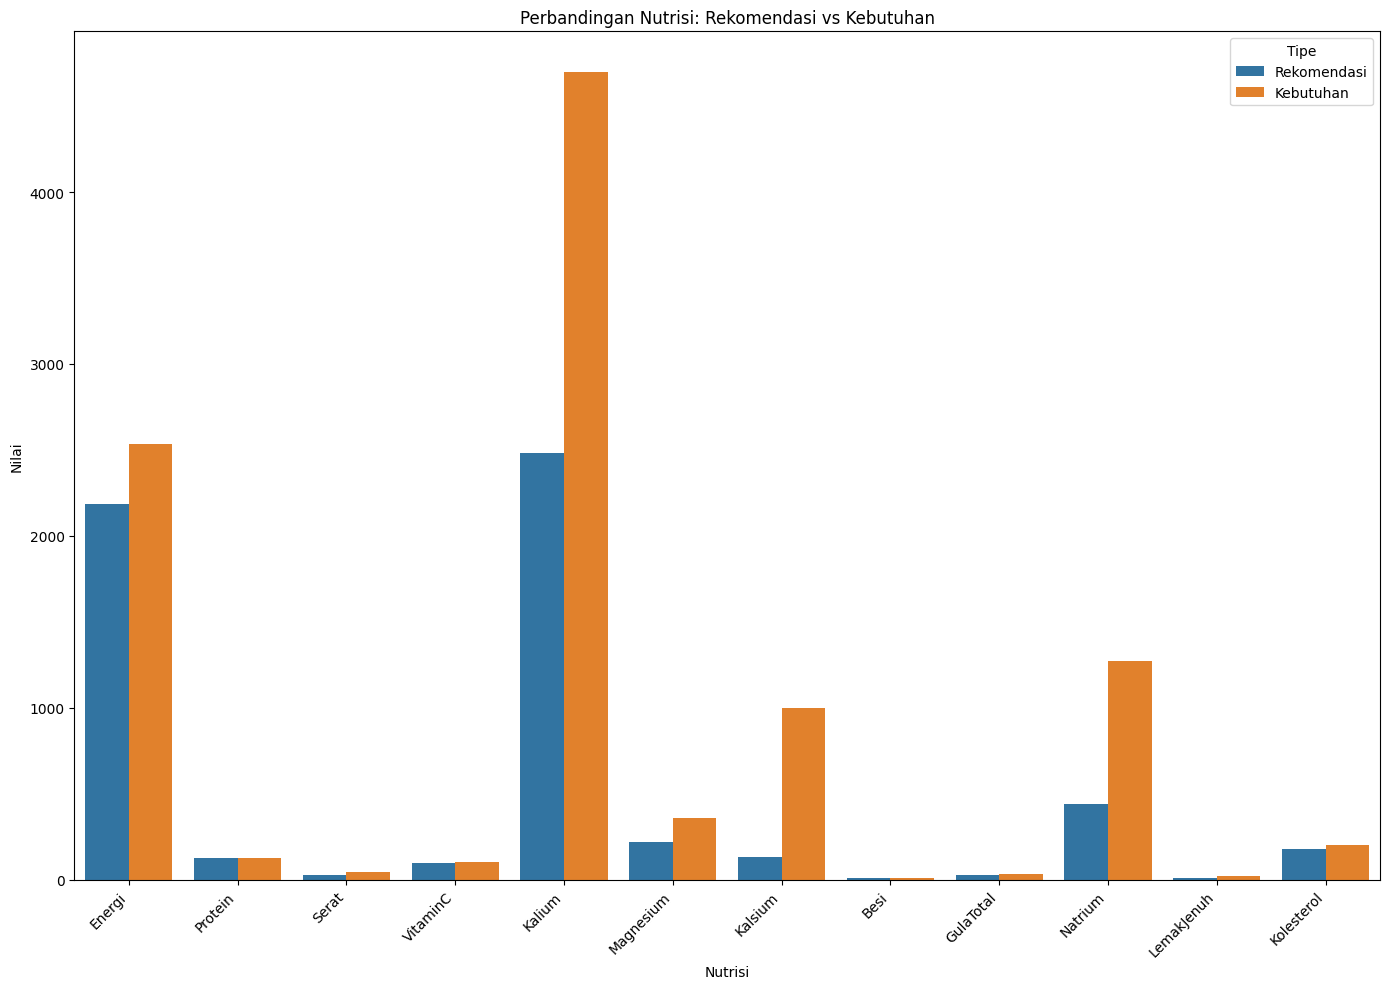


========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========
Energi: 86.31% dari kebutuhan
Protein: 100.23% dari kebutuhan
Serat: 67.92% dari kebutuhan
VitaminC: 93.24% dari kebutuhan
Kalium: 52.83% dari kebutuhan
Magnesium: 61.11% dari kebutuhan
Kalsium: 13.40% dari kebutuhan
Besi: 118.26% dari kebutuhan
GulaTotal: 86.67% dari kebutuhan
Natrium: 34.66% dari kebutuhan
LemakJenuh: 58.00% dari kebutuhan
Kolesterol: 89.00% dari kebutuhan


In [ ]:
def main():
    # Memuat data
    github_url = "https://raw.githubusercontent.com/bachtiarrizkyal/TugasAkhir/refs/heads/main/USDA.xlsx"
    df_usda = pd.read_excel(github_url)

    # Melakukan preprocessing data
    df_preprocessed, scaler, df_original, nutrient_cols = preprocess_data(df_usda)

    # Memproses data pengguna (contoh)
    gender = 'laki-laki'
    age = 22
    height = 170
    weight = 75
    diseases = ['diabetes', 'cardiovascular disease']

    user_info = process_user_data(gender, age, height, weight, diseases)

    # Tampilkan informasi pengguna
    display_user_info(user_info)

    # Menyiapkan data makanan
    df_labeled, df_main, df_side, df_drink_fruit = prepare_food_data(df_preprocessed, user_info, df_original)

    # Melatih model KNN
    knn, X, y, X_train, X_test, y_train, y_test = train_knn_model(df_labeled, user_info)

    # Evaluasi model
    evaluation = evaluate_model(knn, X_test, y_test)

    print("\n========== EVALUASI MODEL ==========")
    print(f"Accuracy: {evaluation['accuracy']:.4f}")
    print(f"Precision: {evaluation['precision']:.4f}")
    print(f"Recall: {evaluation['recall']:.4f}")
    print(f"True Positive (TP): {evaluation['tp']}")
    print(f"False Positive (FP): {evaluation['fp']}")
    print(f"False Negative (FN): {evaluation['fn']}")
    print(f"True Negative (TN): {evaluation['tn']}")

    # Visualisasi confusion matrix
    visualize_confusion_matrix(evaluation['confusion_matrix'])

    # Rekomendasi makanan dengan Fractional Knapsack
    recommended_df = get_recommendation(knn, df_labeled, user_info, df_original)

    # Tampilkan rekomendasi
    display_food_recommendations(recommended_df)

    # Visualisasi perbandingan nutrisi
    comparison = visualize_nutrition_comparison(recommended_df, user_info)

    # Tampilkan persentase pemenuhan nutrisi
    print("\n========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========")
    for _, row in comparison.iterrows():
        print(f"{row['Nutrisi']}: {row['Persentase']:.2f}% dari kebutuhan")

if __name__ == "__main__":
    main()

## **HIPERTENSI dan CARDIOVASCULAR DISEASE**


========== PROFIL PENGGUNA ==========
Jenis Kelamin: Laki-laki
Usia: 22 tahun (dewasa)
Tinggi Badan: 170 cm
Berat Badan: 75 kg
Riwayat Penyakit: Hipertensi, Cardiovascular disease
Preferensi Makanan: Tidak Ada/Tidak Ditentukan

========== INFORMASI KESEHATAN ==========
BMI: 25.95
Kategori BMI: Berat Badan Berlebih (Overweight)
Berat Badan Ideal: 63.00 kg
Kebutuhan Energi: 2533.88 kkal

========== KEBUTUHAN NUTRISI ==========
Energi: 2533.88 kkal
Protein: 126.69 g
Serat: 42.55 g
Gula Total: 63.35 g
Lemak Jenuh: 19.71 g
Vitamin C: 90.00 mg
Magnesium: 414.00 mg
Natrium: 1275.00 mg
Kalsium: 1150.00 mg
Kalium: 5405.00 mg
Besi: 10.35 mg
Kolesterol: 200.00 mg
Fitting 5 folds for each of 7 candidates, totalling 35 fits

--- Hasil Tuning KNN ---
Hyperparameter terbaik (berdasarkan recall): {'metric': 'euclidean', 'n_neighbors': 3}
Nilai recall terbaik pada cross-validation: 0.8073
Akurasi terbaik pada test set: 0.8992
Precision terbaik pada test set: 0.7592
Recall terbaik pada test set: 0.8378

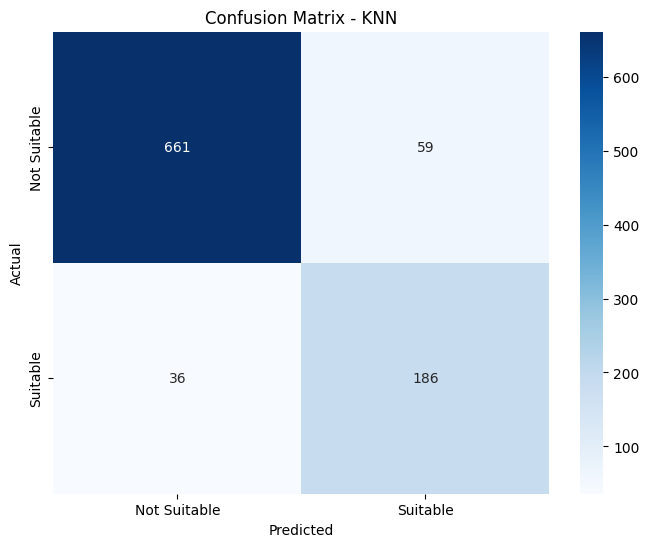

Peringatan: Total Serat (27.80) kurang dari batas minimal harian (34.04 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Serat yang masuk ke dalam tubuh.
Peringatan: Total Kalsium (460.00) kurang dari batas minimal harian (920.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalsium yang masuk ke dalam tubuh.
Peringatan: Total Kalium (3177.00) kurang dari batas minimal harian (4324.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalium yang masuk ke dalam tubuh.

========== REKOMENDASI MAKANAN ==========

----- Sarapan: Makanan Utama -----

Nama Makanan: Biji bayam dimasak
Jenis Makanan (Kategori): Sereal dan Pasta
Energi: 102.00 kkal
Protein: 3.80 g
Serat: 2.10 g
Gula Total: 0.00 g
Lemak Jenuh: 0.00 g
Vitamin C: 0.00 mg
Magnesium: 65.00 mg
Natrium: 6.00 mg
Kalsium: 47.00 mg
Kalium: 135.00 mg
Besi: 2.10 mg
Kolesterol: 0.00 mg

Nama Makanan: Daging babi diawetkan ham steak tanpa tulang lebih ramping tidak dipanaskan
Jenis Maka

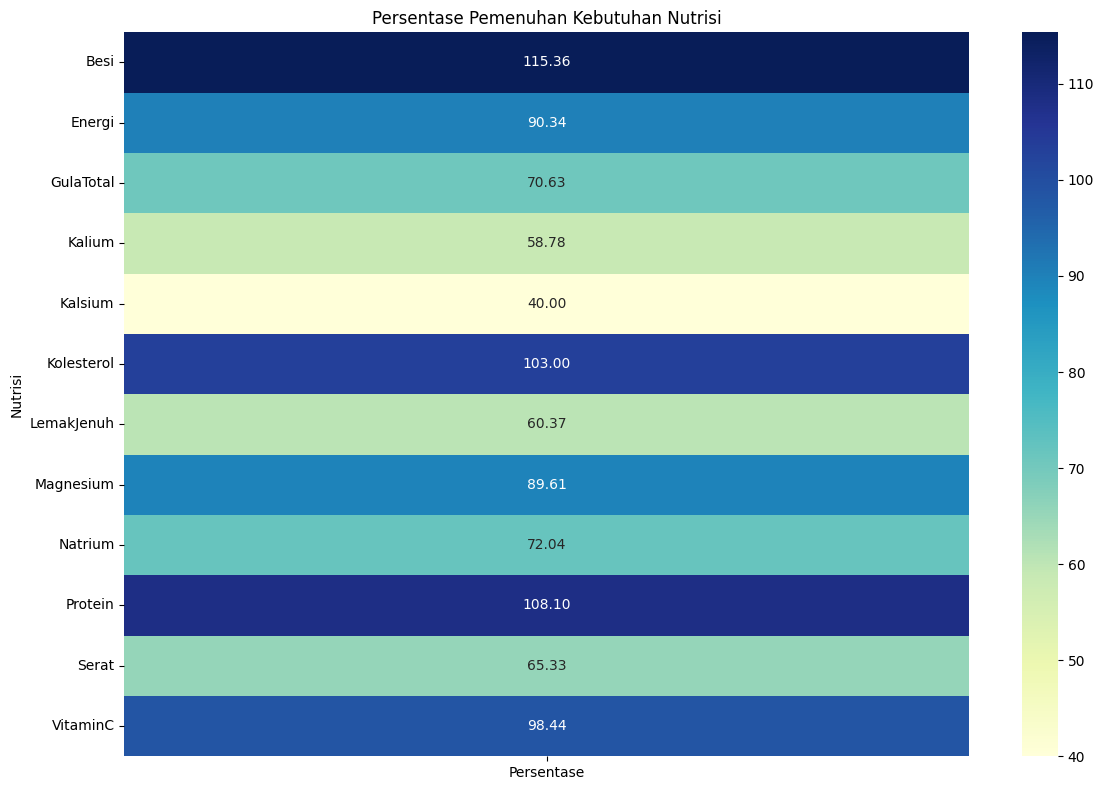

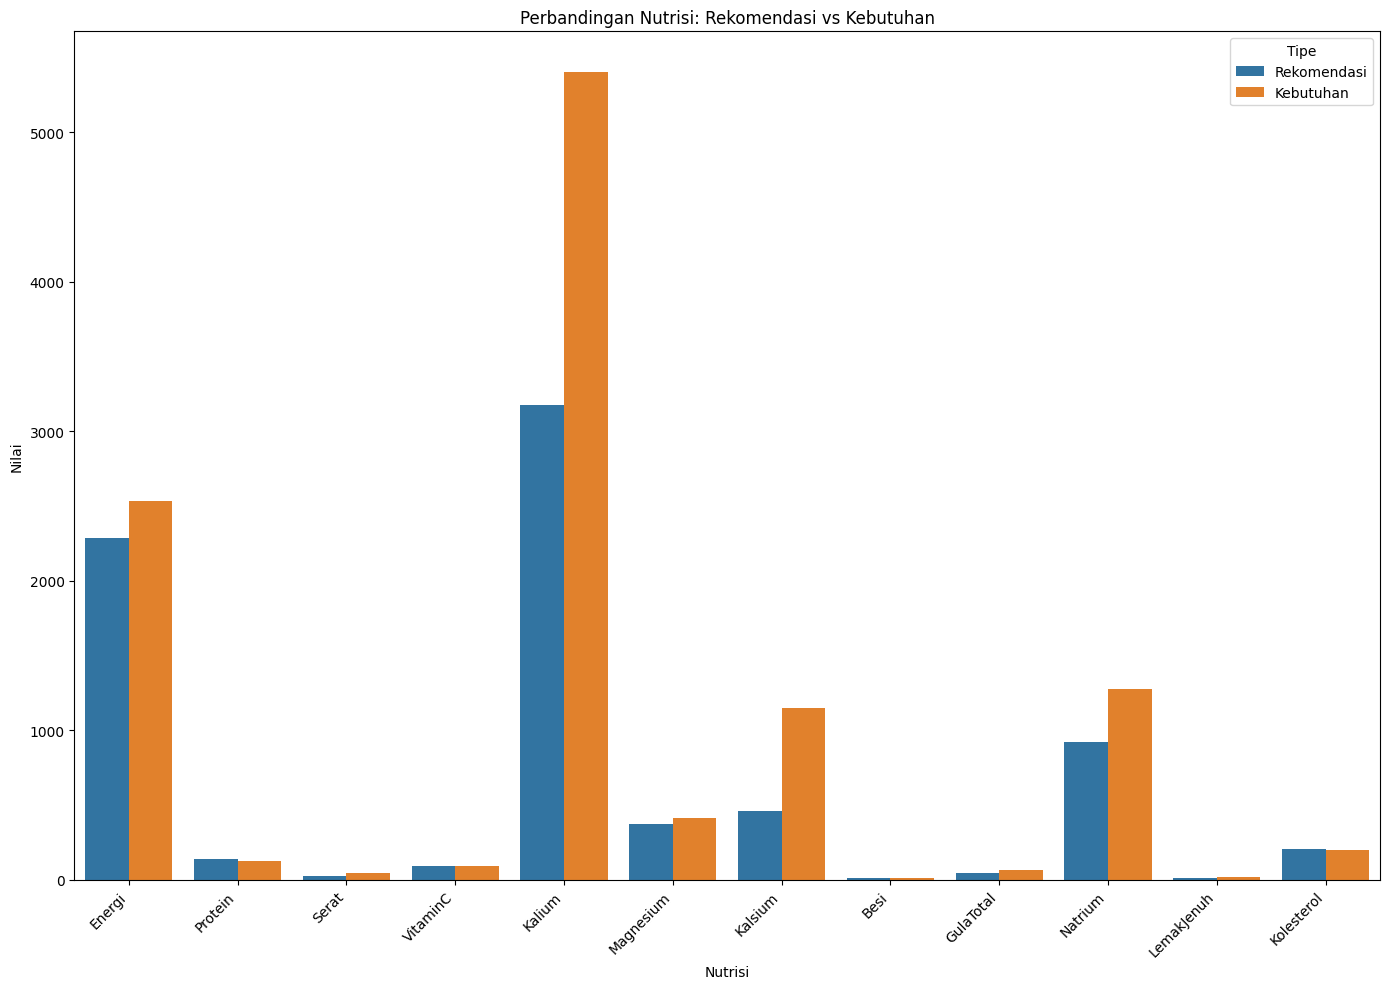


========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========
Energi: 90.34% dari kebutuhan
Protein: 108.10% dari kebutuhan
Serat: 65.33% dari kebutuhan
VitaminC: 98.44% dari kebutuhan
Kalium: 58.78% dari kebutuhan
Magnesium: 89.61% dari kebutuhan
Kalsium: 40.00% dari kebutuhan
Besi: 115.36% dari kebutuhan
GulaTotal: 70.63% dari kebutuhan
Natrium: 72.04% dari kebutuhan
LemakJenuh: 60.37% dari kebutuhan
Kolesterol: 103.00% dari kebutuhan


In [ ]:
def main():
    # Memuat data
    github_url = "https://raw.githubusercontent.com/bachtiarrizkyal/TugasAkhir/refs/heads/main/USDA.xlsx"
    df_usda = pd.read_excel(github_url)

    # Melakukan preprocessing data
    df_preprocessed, scaler, df_original, nutrient_cols = preprocess_data(df_usda)

    # Memproses data pengguna (contoh)
    gender = 'laki-laki'
    age = 22
    height = 170
    weight = 75
    diseases = ['hipertensi', 'cardiovascular disease']

    user_info = process_user_data(gender, age, height, weight, diseases)

    # Tampilkan informasi pengguna
    display_user_info(user_info)

    # Menyiapkan data makanan
    df_labeled, df_main, df_side, df_drink_fruit = prepare_food_data(df_preprocessed, user_info, df_original)

    # Melatih model KNN
    knn, X, y, X_train, X_test, y_train, y_test = train_knn_model(df_labeled, user_info)

    # Evaluasi model
    evaluation = evaluate_model(knn, X_test, y_test)

    print("\n========== EVALUASI MODEL ==========")
    print(f"Accuracy: {evaluation['accuracy']:.4f}")
    print(f"Precision: {evaluation['precision']:.4f}")
    print(f"Recall: {evaluation['recall']:.4f}")
    print(f"True Positive (TP): {evaluation['tp']}")
    print(f"False Positive (FP): {evaluation['fp']}")
    print(f"False Negative (FN): {evaluation['fn']}")
    print(f"True Negative (TN): {evaluation['tn']}")

    # Visualisasi confusion matrix
    visualize_confusion_matrix(evaluation['confusion_matrix'])

    # Rekomendasi makanan dengan Fractional Knapsack
    recommended_df = get_recommendation(knn, df_labeled, user_info, df_original)

    # Tampilkan rekomendasi
    display_food_recommendations(recommended_df)

    # Visualisasi perbandingan nutrisi
    comparison = visualize_nutrition_comparison(recommended_df, user_info)

    # Tampilkan persentase pemenuhan nutrisi
    print("\n========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========")
    for _, row in comparison.iterrows():
        print(f"{row['Nutrisi']}: {row['Persentase']:.2f}% dari kebutuhan")

if __name__ == "__main__":
    main()

## **DIABETES, HIPERTENSI dan CARDIOVASCULAR DISEASE**


========== PROFIL PENGGUNA ==========
Jenis Kelamin: Laki-laki
Usia: 22 tahun (dewasa)
Tinggi Badan: 170 cm
Berat Badan: 75 kg
Riwayat Penyakit: Diabetes, Diabetes, Cardiovascular disease
Preferensi Makanan: Tidak Ada/Tidak Ditentukan

========== INFORMASI KESEHATAN ==========
BMI: 25.95
Kategori BMI: Berat Badan Berlebih (Overweight)
Berat Badan Ideal: 63.00 kg
Kebutuhan Energi: 2533.88 kkal

========== KEBUTUHAN NUTRISI ==========
Energi: 2533.88 kkal
Protein: 126.69 g
Serat: 42.55 g
Gula Total: 31.67 g
Lemak Jenuh: 19.71 g
Vitamin C: 103.50 mg
Magnesium: 360.00 mg
Natrium: 1275.00 mg
Kalsium: 1000.00 mg
Kalium: 4700.00 mg
Besi: 10.35 mg
Kolesterol: 200.00 mg
Fitting 5 folds for each of 7 candidates, totalling 35 fits

--- Hasil Tuning KNN ---
Hyperparameter terbaik (berdasarkan recall): {'metric': 'euclidean', 'n_neighbors': 3}
Nilai recall terbaik pada cross-validation: 0.7447
Akurasi terbaik pada test set: 0.9055
Precision terbaik pada test set: 0.7303
Recall terbaik pada test se

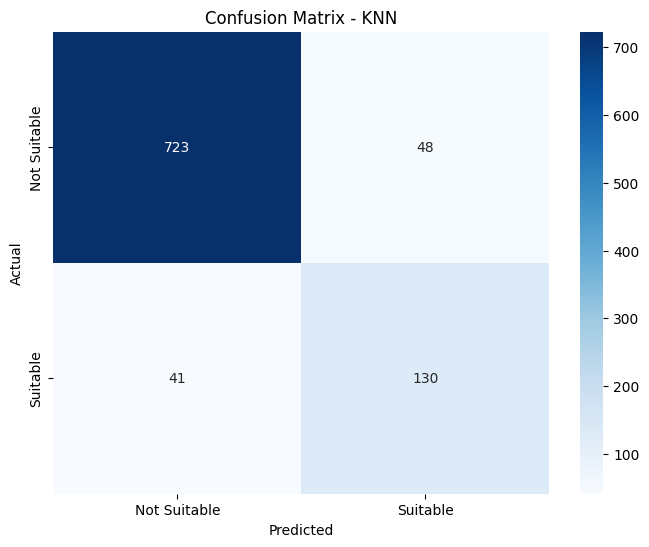

Peringatan: Total Serat (28.90) kurang dari batas minimal harian (34.04 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Serat yang masuk ke dalam tubuh.
Peringatan: Total Magnesium (220.00) kurang dari batas minimal harian (288.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Magnesium yang masuk ke dalam tubuh.
Peringatan: Total Natrium (441.87) kurang dari batas minimal harian (765.00 atau 60% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Natrium yang masuk ke dalam tubuh.
Peringatan: Total Kalsium (134.00) kurang dari batas minimal harian (800.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalsium yang masuk ke dalam tubuh.
Peringatan: Total Kalium (2483.00) kurang dari batas minimal harian (3760.00 atau 80% dari kebutuhan). Tambahkan suplemen untuk menambah jumlah Kalium yang masuk ke dalam tubuh.

========== REKOMENDASI MAKANAN ==========

----- Sarapan: Makanan Utama -----

Nama Makanan: Pastrami daging sa

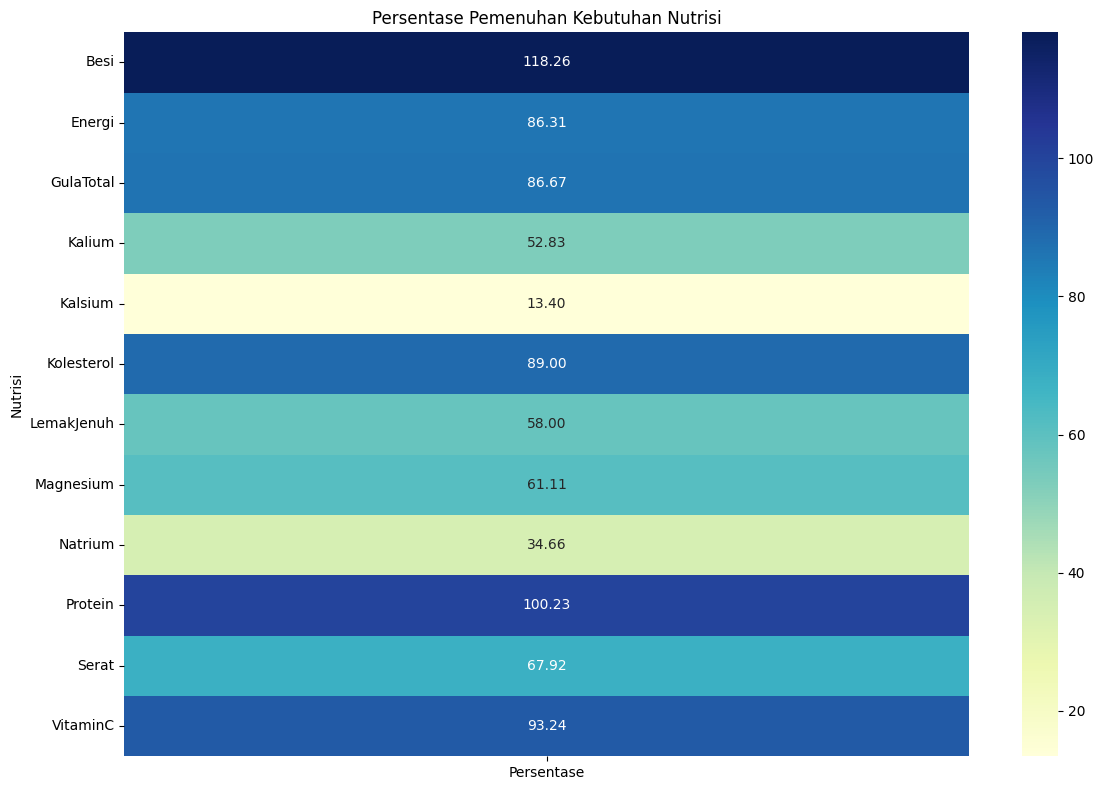

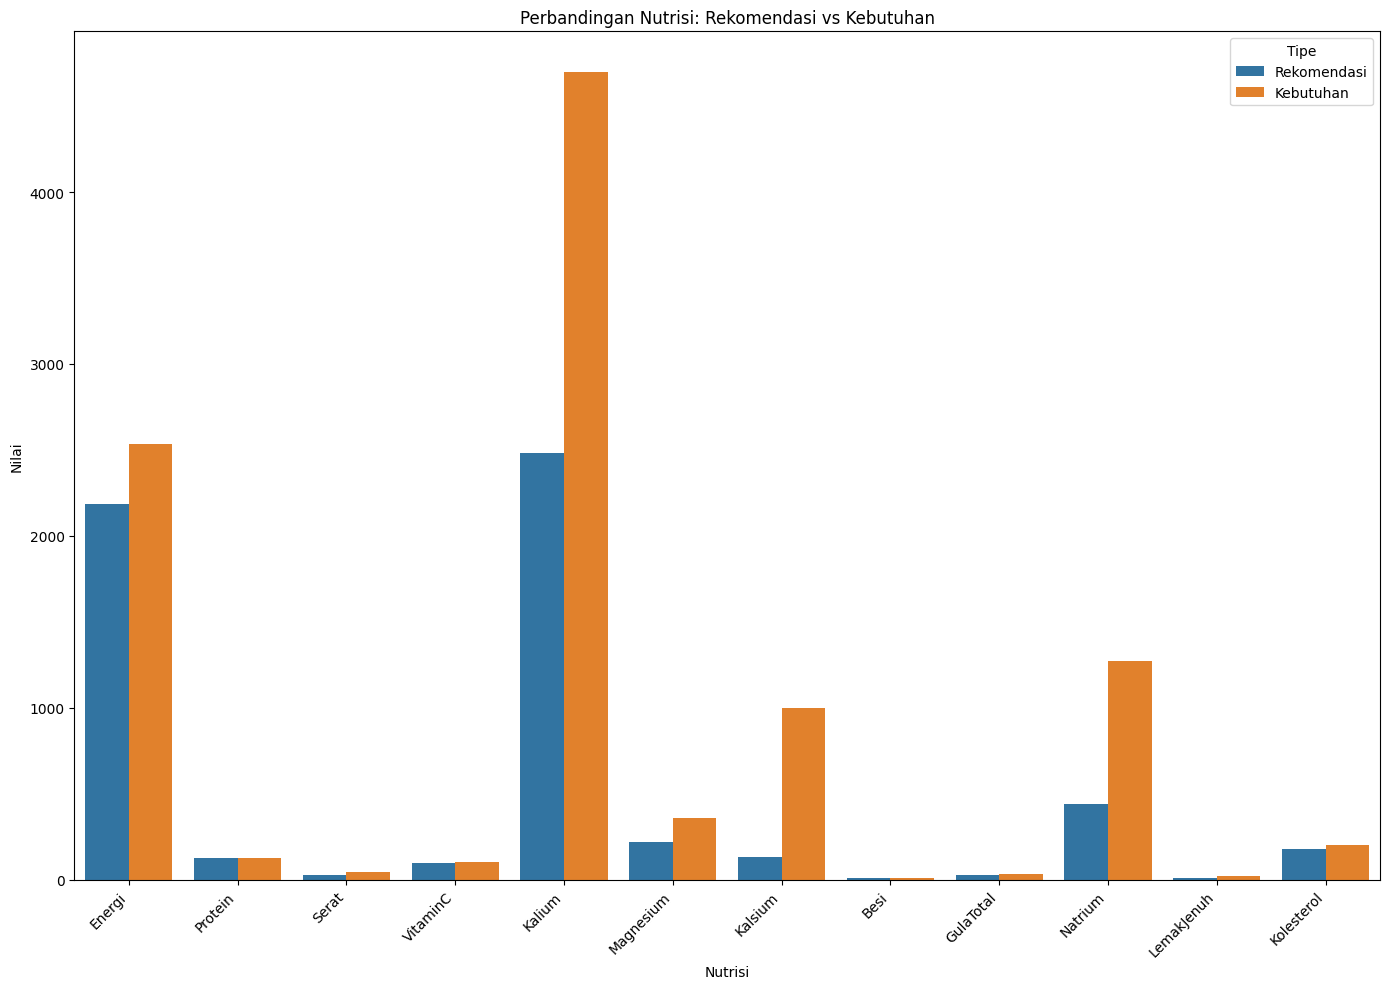


========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========
Energi: 86.31% dari kebutuhan
Protein: 100.23% dari kebutuhan
Serat: 67.92% dari kebutuhan
VitaminC: 93.24% dari kebutuhan
Kalium: 52.83% dari kebutuhan
Magnesium: 61.11% dari kebutuhan
Kalsium: 13.40% dari kebutuhan
Besi: 118.26% dari kebutuhan
GulaTotal: 86.67% dari kebutuhan
Natrium: 34.66% dari kebutuhan
LemakJenuh: 58.00% dari kebutuhan
Kolesterol: 89.00% dari kebutuhan


In [ ]:
def main():
    # Memuat data
    github_url = "https://raw.githubusercontent.com/bachtiarrizkyal/TugasAkhir/refs/heads/main/USDA.xlsx"
    df_usda = pd.read_excel(github_url)

    # Melakukan preprocessing data
    df_preprocessed, scaler, df_original, nutrient_cols = preprocess_data(df_usda)

    # Memproses data pengguna (contoh)
    gender = 'laki-laki'
    age = 22
    height = 170
    weight = 75
    diseases = ['diabetes', 'diabetes', 'cardiovascular disease']

    user_info = process_user_data(gender, age, height, weight, diseases)

    # Tampilkan informasi pengguna
    display_user_info(user_info)

    # Menyiapkan data makanan
    df_labeled, df_main, df_side, df_drink_fruit = prepare_food_data(df_preprocessed, user_info, df_original)

    # Melatih model KNN
    knn, X, y, X_train, X_test, y_train, y_test = train_knn_model(df_labeled, user_info)

    # Evaluasi model
    evaluation = evaluate_model(knn, X_test, y_test)

    print("\n========== EVALUASI MODEL ==========")
    print(f"Accuracy: {evaluation['accuracy']:.4f}")
    print(f"Precision: {evaluation['precision']:.4f}")
    print(f"Recall: {evaluation['recall']:.4f}")
    print(f"True Positive (TP): {evaluation['tp']}")
    print(f"False Positive (FP): {evaluation['fp']}")
    print(f"False Negative (FN): {evaluation['fn']}")
    print(f"True Negative (TN): {evaluation['tn']}")

    # Visualisasi confusion matrix
    visualize_confusion_matrix(evaluation['confusion_matrix'])

    # Rekomendasi makanan dengan Fractional Knapsack
    recommended_df = get_recommendation(knn, df_labeled, user_info, df_original)

    # Tampilkan rekomendasi
    display_food_recommendations(recommended_df)

    # Visualisasi perbandingan nutrisi
    comparison = visualize_nutrition_comparison(recommended_df, user_info)

    # Tampilkan persentase pemenuhan nutrisi
    print("\n========== PERSENTASE PEMENUHAN KEBUTUHAN NUTRISI ==========")
    for _, row in comparison.iterrows():
        print(f"{row['Nutrisi']}: {row['Persentase']:.2f}% dari kebutuhan")

if __name__ == "__main__":
    main()